# Construire un modèle de scoring pour une société financière "Prêt à dépenser"


In [1]:
#importation des librairies
import pandas as pd
import numpy as np
from math import pi
import matplotlib.pyplot as plt
import seaborn as sns
#qgrid pour consulter facilement le fichier avec les descriptions des colonnes 
import qgrid
from sklearn.impute import  SimpleImputer 
from sklearn.model_selection import GridSearchCV,train_test_split, learning_curve,cross_validate, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.linear_model import LogisticRegression,SGDClassifier,LassoCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, accuracy_score,precision_score,recall_score,f1_score
from sklearn.metrics import roc_curve,roc_auc_score,auc ,plot_roc_curve, precision_recall_curve
from sklearn.feature_selection import f_classif,RFE,SelectFromModel
from sklearn.naive_bayes import GaussianNB
#from sklearn.datasets import make_classification

In [2]:
#DEFINITION DES FUNCTIONS
def outlier(dfr,column):
    #cette fonction permet d'identifier les outliers
    lower_bound, upper_bound = np.nanpercentile(dfr[column],[1,99])
    return lower_bound,upper_bound

def suppression_oulier(dfr,columns):
    #cette fonction permet de supprimer les outliers
    for column in columns:
        max = outlier(dfr,column)[1]
        dfr[column] = np.where(dfr[column] > max,np.nan,dfr[column])
    return dfr  

def nettoyage_de_donnees(dfr):
    #cette fonction permet de nettoyer les données
    #suppression des valeurs aberranter DAYS_EMPLOYED
    dfr['DAYS_EMPLOYED'] = dfr['DAYS_EMPLOYED'].replace({365243: np.nan})
    #suppression les colonnes ayant plus de 60% valeurs vides
    missing_rate = dfr.isna().sum()/dfr.shape[0]
    dfr.drop(list(df.columns[(missing_rate > 0.6)]),1,inplace=True)
    #suppression doutlier pour certains montants
    num_col = ['AMT_INCOME_TOTAL','AMT_ANNUITY','AMT_CREDIT','AMT_GOODS_PRICE']  
    dfr = suppression_oulier(dfr,num_col)
    #selection des variables qualitatives
    categorical_var = dfr.select_dtypes('object').columns
    #selection des valeurs quantitative
    numerical_var = [column for column in dfr.columns if column not in categorical_var]
    #remplacement les valeurs quantitative vides par une moyenne
    dfr[numerical_var] = SimpleImputer(missing_values=np.NaN, strategy='mean').fit_transform(dfr[numerical_var])
    #remplacement les valeurs qualitatives vides par la valeur la plus fréquente
    dfr[categorical_var] = SimpleImputer(missing_values=np.NaN, strategy='most_frequent').fit_transform(dfr[categorical_var])
    return dfr 

def preprocessing(dfr):
    #cette fonction permet de préparer les données et
    #les séparer en X1, X2, ... : variables explicatives et  Y : variable cible  
    dfr = nettoyage_de_donnees(dfr)
    X = dfr.drop('TARGET',axis = 1)
    y = dfr['TARGET']
    return X,y

def transformer(X):
    #cette fonction permet de transformer les données
    #conversion des string colonnes en one-hot 
    X = pd.get_dummies(X)
    #standardisation des variables numériques
    X_std = StandardScaler().fit_transform(X)
    X_df = pd.DataFrame(X_std, index=X.index, columns=X.columns)
    return X_df

def table_compare_models(models,X,y,folds,scoring,scoring_name):
    #cette fonction permet de comparer differents modèle en fonction des scores
    models_scores  = {}
    for name, model in models:
        classifier = model
        clf = cross_validate(classifier, X, y, cv=folds, scoring=scoring)
        models_scores[name] = [clf['test_accuracy'].mean(),clf['test_precision'].mean(),
                               clf['test_recall'].mean(),clf['test_f1_score'].mean(),clf['test_roc_auc'].mean()] 
    models_scores_table = pd.DataFrame(models_scores, index = scoring_name)
    # Add 'Best Score' column
    models_scores_table['Best Score'] = models_scores_table.idxmax(axis=1)
    # Return models performance metrics scores data frame
    return(models_scores_table)

def cross_validation_ROC(models,X,y,cv):
    #cette fonction effectue la cross-validation and affiche plot ROC curves
    for name, classifier in models:
        
        tprs = []
        aucs = []
        mean_fpr = np.linspace(0, 1, 100)

        fig, ax = plt.subplots(figsize=(10, 10))
        i=1
        for train, test in cv.split(X, y):
            model = classifier
            model.fit(X.iloc[train], y.iloc[train])
            viz = plot_roc_curve(classifier, X.iloc[test], y.iloc[test],
                                 name='ROC fold {}'.format(i),
                                 alpha=0.3, lw=1, ax=ax)
            interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
            interp_tpr[0] = 0.0
            
            tprs.append(interp_tpr)
            aucs.append(viz.roc_auc)

            i=i+1
       
        ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
                label='Baseline', alpha=.8)

        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0

        mean_auc = auc(mean_fpr, mean_tpr)
        std_auc = np.std(aucs)
        ax.plot(mean_fpr, mean_tpr, color='m',
                label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
                lw=2, alpha=.8)
        plt.fill_between(mean_fpr, mean_tpr, color='lavenderblush')
        plt.grid()
        std_tpr = np.std(tprs, axis=0)
        tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
        ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='pink', alpha=.2,
                        label=r'$\pm$ 1 std. dev.')

        #ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],title="Receiver operating characteristic example")
        ax.legend(loc="lower right")
        plt.title("Receiver operating characteristic \n" + name)
        plt.show()
    

def vizualization_learning_curve(models,X,y,folds):
    #cette fonction permet de visualiser learning_curve
    for name, model in models:
        N,train_score, val_score,fit_times,score_times = learning_curve(model,X,y,cv=folds,scoring='roc_auc',return_times = True)
        print(fit_times.mean(),score_times.mean())
        plt.figure(figsize=(10,10))
        plt.plot(N,train_score.mean(axis = 1),label = 'Train score',color ='m')
        plt.plot(N,val_score.mean(axis = 1),label = 'Validation score',color ='b')
        plt.legend()
        plt.title(name)
        plt.show()

def visualization_crosstab(dfr,columns_cross,height=7, aspect=.9):
    #cette fonction permet de visualiser les plots crosstab
    t = pd.crosstab([dfr[columns_cross]], dfr['TARGET'], normalize = "index")
    t = t.assign(Features = t.index)
    tm = pd.melt(t, id_vars="Features")
    tm = tm.assign(pourcentage = 100 * tm.value)
    g = sns.catplot(x = "pourcentage", y = "Features" , hue = 'TARGET', data = tm, palette='PuRd',
                       kind = "bar",height=height, aspect=aspect)
    plt.show()
    
def plot_pourcentage(dfr,colHue,col,figsize = (10,7)):
    #cette fonction permet de visualiser les pourcentages
    plt.figure(figsize=figsize)
    counts = (dfr.groupby([colHue])[col]
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values(col))
    p = sns.barplot(x=col, y="percentage", hue=colHue, data=counts,palette='PuRd')
    plt.setp(p.get_xticklabels(), rotation=45)  # Rotate labels
    plt.title('POURCENTAGE '+ col +' PAR '+ colHue)


In [3]:
#To turn off the false positives SettingWithCopyWarning
#situations where a chained assignment is inadvertantly reported.
pd.set_option('chained_assignment',None)
np.seterr(divide='ignore', invalid='ignore');
#affichage toutes les colonnes de DataFrame
pd.set_option('display.max_columns', None)

## 1. Chargement  et analyse exploratoire de données

## 1.1 Chargement des données

Nous avons en total 9 fichiers:
 - HomeCredit_columns_description.csv - fichier HomeCredit_columns_description.csv contient une description de toutes les variables présentes dans les autres fichiers 
 
 Données principales contenant des informations sur chaque demande de prêt:
 - application_train.csv - données d’entrainement
 - application_test.csv - données de test
 
 Données sur les crédits précédents:
 - bureau.csv - données relatives aux crédits antérieurs du client auprès d'autres institutions financières
   - bureau_balance.csv - données mensuelles sur les crédits précédents du client auprès d'autres institutions financières 
   
 - previous_application.csv - demandes antérieures de prêts à l'établissement concernant les clients qui ont des prêts en cours 
   - POS_CASH_balance.csv - données mensuelles sur les prêts précédents
   - Installments_payments.csv - historique des paiements pour les prêts précédents 
   - credit_card_balance.csv - données mensuelles sur les anciennes cartes de crédit 
 
 
    

Importation des fichiers concernant les données financières

In [4]:
#une liste des valeurs qui doivent être assimilées à NaN (valeur non définie) :
missing_values =  ['XNA','Unknown']
# Importation des fichiers
# Le fichier HomeCredit_columns_description.csv contient une description de toutes les variables présentes dans autres fichiers 
data_columns_description = pd.read_csv('HomeCredit_columns_description.csv', encoding = "cp1252")
# Les données principales contenant des informations sur chaque demande de prêt:
## les données d’entrainement
data_application_train = pd.read_csv('application_train.csv',na_values = missing_values)
## les données de test
data_application_test = pd.read_csv('application_test.csv',na_values = missing_values)
# données relatives aux crédits antérieurs du client auprès d'autres institutions financières 
data_bureau = pd.read_csv('bureau.csv',na_values = missing_values)
# les données mensuelles sur les crédits précédents du client auprès d'autres institutions financières 
data_bureau_balance = pd.read_csv('bureau_balance.csv',na_values = missing_values)
# les demandes antérieures de prêts au crédit immobilier des clients qui ont des prêts en cours
previous_application = pd.read_csv('previous_application.csv',na_values = missing_values)
#les données mensuelles sur les prêts précédents
pos_cash_balance = pd.read_csv('POS_CASH_balance.csv',na_values = missing_values)
# historique des paiements pour les prêts précédents 
installments_payments = pd.read_csv('Installments_payments.csv',na_values = missing_values)
# données mensuelles sur les anciennes cartes de crédit 
credit_card_balance = pd.read_csv('credit_card_balance.csv',na_values = missing_values)


## 1.2. Analyse exploratoire de données

Nous allons utiliser qgrid pour afficher les données HomeCredit_columns_description et pouvoir trouver facilement les descriptions des variables pour chaque fichier.

In [5]:
qgrid.show_grid(data_columns_description, show_toolbar = True)


QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

### 1.2.1. Fichiers application_train/application_test 

In [6]:
df = data_application_train.copy()

In [7]:
data_application_train.shape

(307511, 122)

In [8]:
data_application_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [9]:
data_application_test.shape

(48744, 121)

In [10]:
data_application_test.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,Unaccompanied,Working,Higher education,Married,House / apartment,0.018850,-19241,-2329,-5170.0,-812,NaN,1,1,0,1,0,1,NaN,2.0,2,2,TUESDAY,18,0,0,0,0,0,0,Kindergarten,0.752614,0.789654,0.159520,0.0660,0.0590,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0505,NaN,NaN,0.0672,0.0612,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0526,NaN,NaN,0.0666,0.0590,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0514,NaN,NaN,NaN,block of flats,0.0392,"Stone, brick",No,0.0,0.0,0.0,0.0,-1740.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.035792,-18064,-4469,-9118.0,-1623,NaN,1,1,0,1,0,0,Low-skill Laborers,2.0,2,2,FRIDAY,9,0,0,0,0,0,0,Self-employed,0.564990,0.291656,0.432962,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,NaN,Working,Higher education,Married,House / apartment,0.019101,-20038,-4458,-2175.0,-3503,5.0,1,1,0,1,0,0,Drivers,2.0,2,2,MONDAY,14,0,0,0,0,0,0,Transport: type 3,NaN,0.699787,0.610991,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-856.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,Unaccompanied,Working,Secondary / secondary special,Married

La DataFrame data_application_test ne contient pas la colonne TARGET. La DataFrame data_application_train sera utilisée pour l'entrainement et le test. 

### Valeurs manquantes

In [11]:
total = data_application_train.isnull().sum().sort_values(ascending=False)
percent = (data_application_train.isnull().sum()/data_application_train.isnull().count()).sort_values(ascending=False)*100
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Pct %'])
missing_data[missing_data['Pct %']> 60.0]

,Total,Pct %
COMMONAREA_AVG,214865,69.872297
COMMONAREA_MODE,214865,69.872297
COMMONAREA_MEDI,214865,69.872297
NONLIVINGAPARTMENTS_AVG,213514,69.432963
NONLIVINGAPARTMENTS_MEDI,213514,69.432963
NONLIVINGAPARTMENTS_MODE,213514,69.432963
FONDKAPREMONT_MODE,210295,68.386172
LIVINGAPARTMENTS_MODE,210199,68.354953
LIVINGAPARTMENTS_MEDI,210199,68.354953
LIVINGAPARTMENTS_AVG,210199,68.354953


Les colonnes ayant plus de 60% de valeurs absentes seront supprimées

In [12]:
#Verification du nombre et pourcentage des valeurs manquantes
totalValeurs = data_application_train.size
num_nans = totalValeurs - data_application_train.count().sum()
pct = (num_nans/totalValeurs)*100
print(f"Pourcentage de valeurs manquantes: {pct:4.2f} %")

Pourcentage de valeurs manquantes: 24.54 %


In [13]:
# Number of each type of column
data_application_train.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

In [14]:
# Number of unique classes in each object column
data_application_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    2
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             5
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             57
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

In [15]:
data_application_train.describe(include ='all')

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,307511,307507,307511,307511,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,306219,307511,307511,307509,307511,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,104582.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,211120,307509.000000,307511.000000,307511.000000,307511,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,252137,134133.000000,3.068510e+05,246546.000000,151450.00000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,151450.000000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,151450.000000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,97216,153214,159080.000000,151170,161756,306490.000000,306490.000000,306490.000000,306490.000000,307510.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.00000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
unique,NaN,NaN,2,2,2,2,NaN,NaN,NaN,NaN,NaN,7,8,5,5,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18,NaN,NaN,NaN,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

### Analyse de variables

#### Variable TARGET

Les valeurs: 
 - 0: le prêt a été remboursé
 - 1: le prêt n'a pas été remboursé 


In [16]:
data_application_train['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

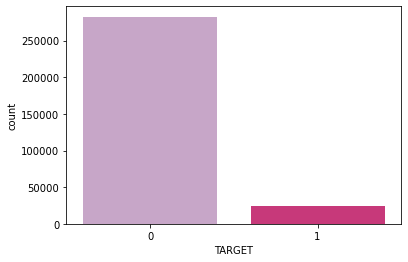

In [17]:
sns.countplot(x = data_application_train['TARGET'],palette = 'PuRd');

In [18]:
#Pourcentage de TARGET à 0
(data_application_train[data_application_train['TARGET']==1].shape[0]/data_application_train.shape[0])*100

8.072881945686495

Nous constatons que les valeurs de variable target (1 et 0) n’ont pas les proportions équilibrées. La DataFraime contient 8% des lignes ayant le TARGET à 1. Lors de l’entrainement nous avons besoin d’utiliser une méthode de stratification.

#### Variable SK_ID_CURR

Vérification les valeurs vides et les doublons pour la variable clé

In [19]:
data_application_train['SK_ID_CURR'].isnull().sum()

0

In [20]:
#Vérification  des doublons
data_application_train.duplicated(subset=['SK_ID_CURR']).sum()

0

#### Variable CODE_GENDER

In [21]:
data_application_train['CODE_GENDER'].value_counts()

F    202448
M    105059
Name: CODE_GENDER, dtype: int64

In [22]:
data_application_train['CODE_GENDER'].isnull().sum()

4

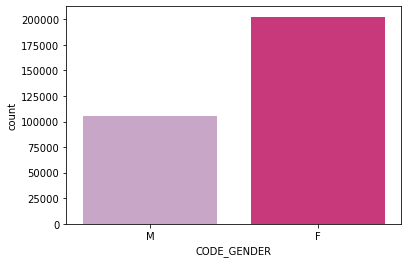

In [23]:
sns.countplot(x = data_application_train['CODE_GENDER'],palette = 'PuRd');

In [24]:
#Pourcentage de femmes
(data_application_train[data_application_train['CODE_GENDER']=='F'].shape[0]/data_application_train.shape[0])*100

65.83439291602576

Nous constatons que parmis les demandeurs de crédit le pourcentage de femmes est 66%

#### Variable CNT_CHILDREN

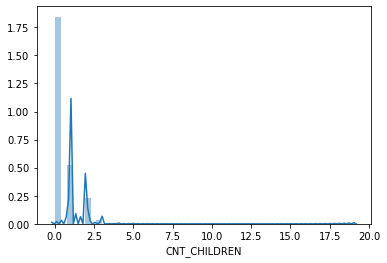

In [25]:
sns.distplot(data_application_train['CNT_CHILDREN']);

In [26]:
data_application_train["CNT_CHILDREN"].unique()

array([ 0,  1,  2,  3,  4,  7,  5,  6,  8,  9, 11, 12, 10, 19, 14])

#### Variable AMT_CREDIT

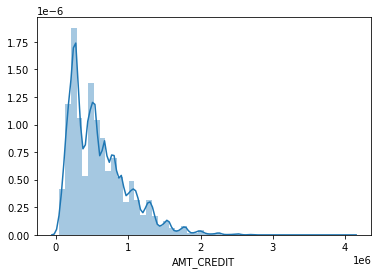

In [27]:
sns.distplot(data_application_train['AMT_CREDIT']);

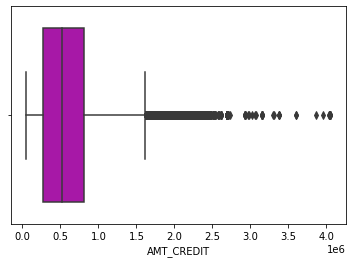

In [28]:
sns.boxplot(y="AMT_CREDIT",orient="h",color = 'm',data=data_application_train);

In [29]:
data_application_train['AMT_CREDIT'].max()

4050000.0

#### Variable DAYS_EMPLOYED

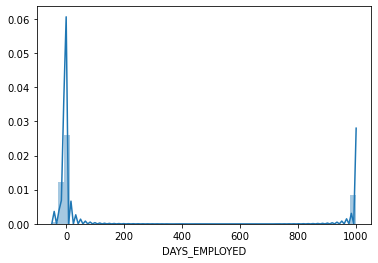

In [30]:
sns.distplot(data_application_train['DAYS_EMPLOYED']/365);

In [31]:
(data_application_train['DAYS_EMPLOYED'] / 365).describe()

count    307511.000000
mean        174.835742
std         387.056895
min         -49.073973
25%          -7.561644
50%          -3.323288
75%          -0.791781
max        1000.665753
Name: DAYS_EMPLOYED, dtype: float64

In [32]:
(data_application_train['DAYS_EMPLOYED']).describe()

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

Une valeur aberrante 365243 (1000 ans) est présente.

#### Variable DAYS_BIRTH

In [33]:
(data_application_train['DAYS_BIRTH'] / -365).describe()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

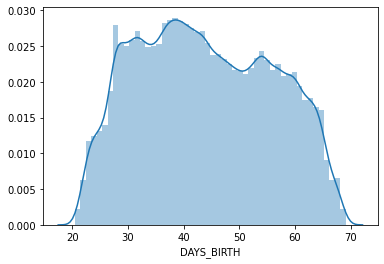

In [34]:
sns.distplot(data_application_train['DAYS_BIRTH']/-365);

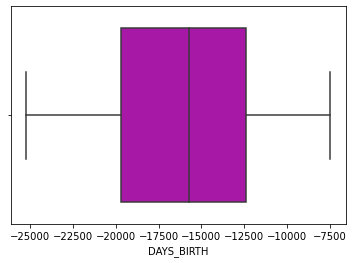

In [35]:
sns.boxplot(y="DAYS_BIRTH",orient="h",color = 'm',data=data_application_train);

### Correlations les plus importantes avec la variable TARGET

In [36]:
#On cherche les correlations les plus importantes
correlations = data_application_train.corr()['TARGET'].sort_values()
print('Correlations positives:\n', correlations.tail(10))
print('\nCorrelations negatives :\n', correlations.head(10))

Correlations positives:
 FLAG_DOCUMENT_3                0.044346
REG_CITY_NOT_LIVE_CITY         0.044395
FLAG_EMP_PHONE                 0.045982
REG_CITY_NOT_WORK_CITY         0.050994
DAYS_ID_PUBLISH                0.051457
DAYS_LAST_PHONE_CHANGE         0.055218
REGION_RATING_CLIENT           0.058899
REGION_RATING_CLIENT_W_CITY    0.060893
DAYS_BIRTH                     0.078239
TARGET                         1.000000
Name: TARGET, dtype: float64

Correlations negatives :
 EXT_SOURCE_3                 -0.178919
EXT_SOURCE_2                 -0.160472
EXT_SOURCE_1                 -0.155317
DAYS_EMPLOYED                -0.044932
FLOORSMAX_AVG                -0.044003
FLOORSMAX_MEDI               -0.043768
FLOORSMAX_MODE               -0.043226
AMT_GOODS_PRICE              -0.039645
REGION_POPULATION_RELATIVE   -0.037227
ELEVATORS_AVG                -0.034199
Name: TARGET, dtype: float64


### Répartition des distributions pour différentes variables quantitatives par TARGET positive et négatives  

In [37]:
positive = data_application_train[data_application_train['TARGET']==1]
negative = data_application_train[data_application_train['TARGET']==0]

#### Distribution des jours et External source

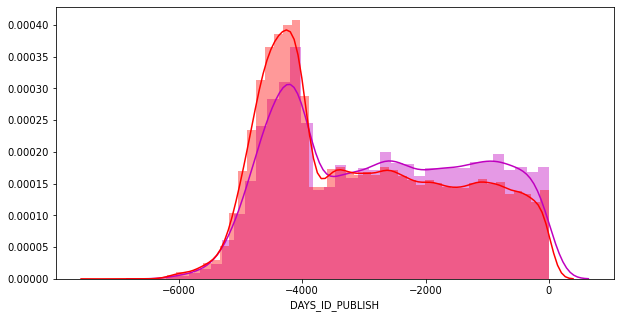

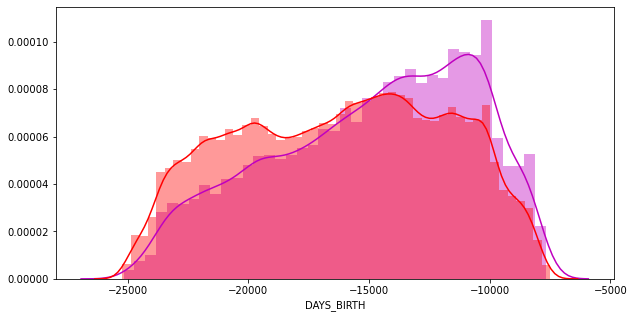

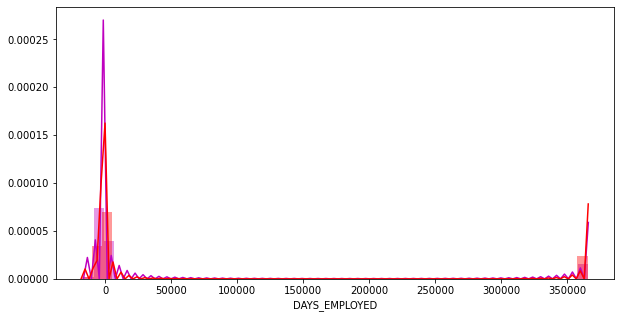

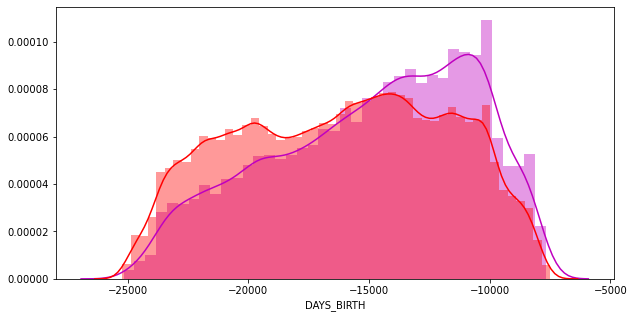

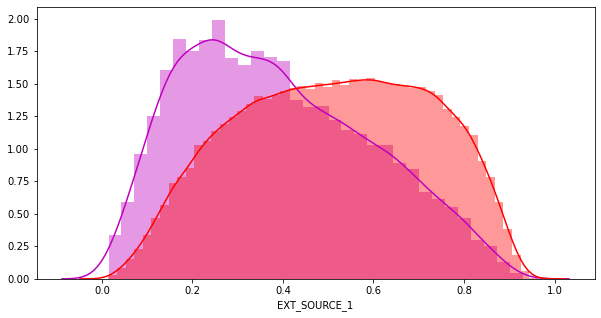

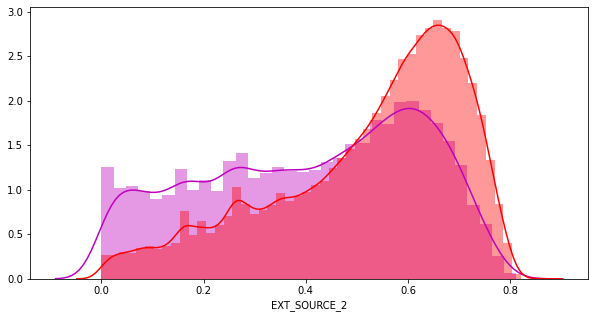

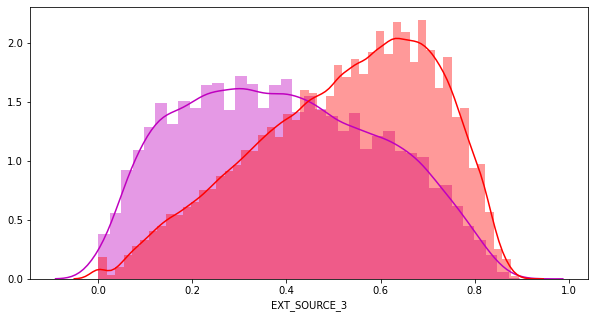

In [38]:
for col in ['DAYS_ID_PUBLISH', 'DAYS_BIRTH','DAYS_EMPLOYED','DAYS_BIRTH',
            'EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3']:
    plt.figure(figsize=(10,5))
    sns.distplot(positive[col],color = 'm');
    sns.distplot(negative[col],color = 'r');
    plt.show()

#### Distributions des montants

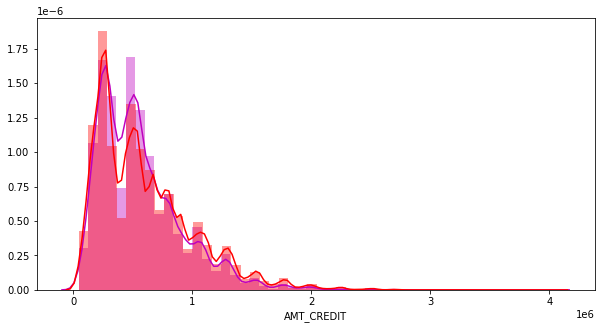

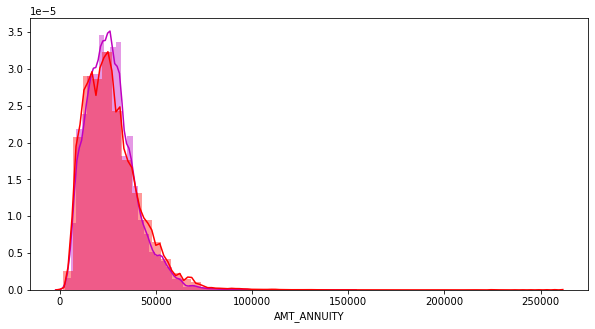

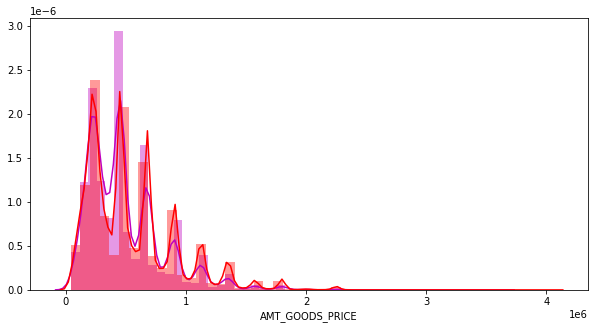

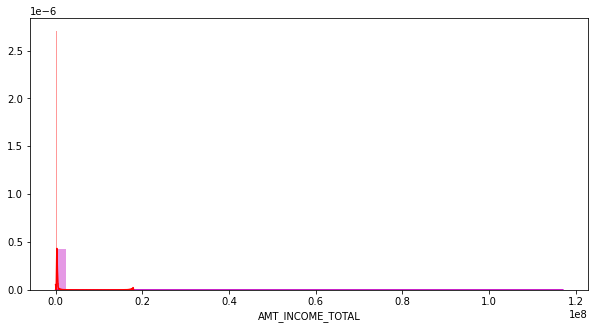

In [39]:
for col in ['AMT_CREDIT','AMT_ANNUITY','AMT_GOODS_PRICE','AMT_INCOME_TOTAL']:
    plt.figure(figsize=(10,5))
    sns.distplot(positive[col],color = 'm');
    sns.distplot(negative[col],color = 'r');
    plt.show()

In [40]:
data_application_train['AMT_INCOME_TOTAL'].max()

117000000.0

Vérification des outlier pour 'AMT_INCOME_TOTAL'

In [41]:
outlier(data_application_train,'AMT_INCOME_TOTAL')

(45000.0, 472500.0)

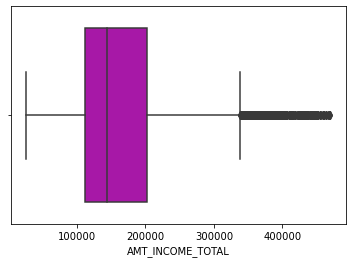

In [42]:
sns.boxplot(y="AMT_INCOME_TOTAL",orient="h",color = 'm',data=data_application_train[data_application_train['AMT_INCOME_TOTAL'] < 472500.0]);

### Analyse données age

In [43]:
data_age = data_application_train[['TARGET', 'DAYS_BIRTH','CODE_GENDER']]
data_age.loc[:,'YEARS_OLD'] = data_age['DAYS_BIRTH']/-365
data_age.loc[:,'AGE_GROUP'] = pd.cut(data_age['YEARS_OLD'], bins = np.linspace(20, 70, num = 11))

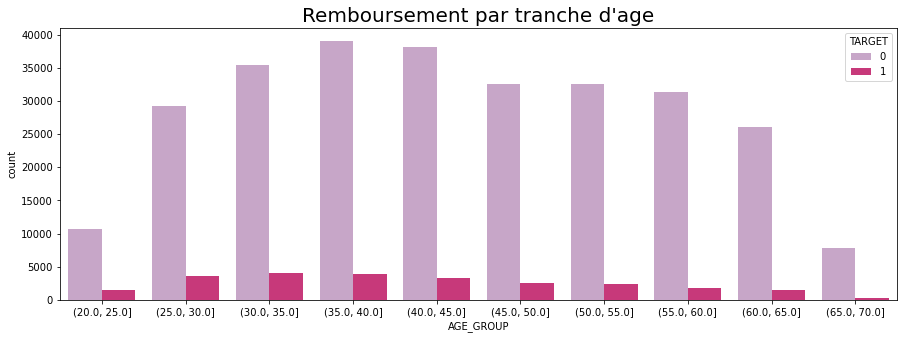

In [44]:
plt.figure(figsize=(15,5))
sns.countplot( x="AGE_GROUP",hue="TARGET",data=data_age, palette = 'PuRd')
plt.title("Remboursement par tranche d'age",fontsize=20);

<Figure size 720x64.8 with 0 Axes>

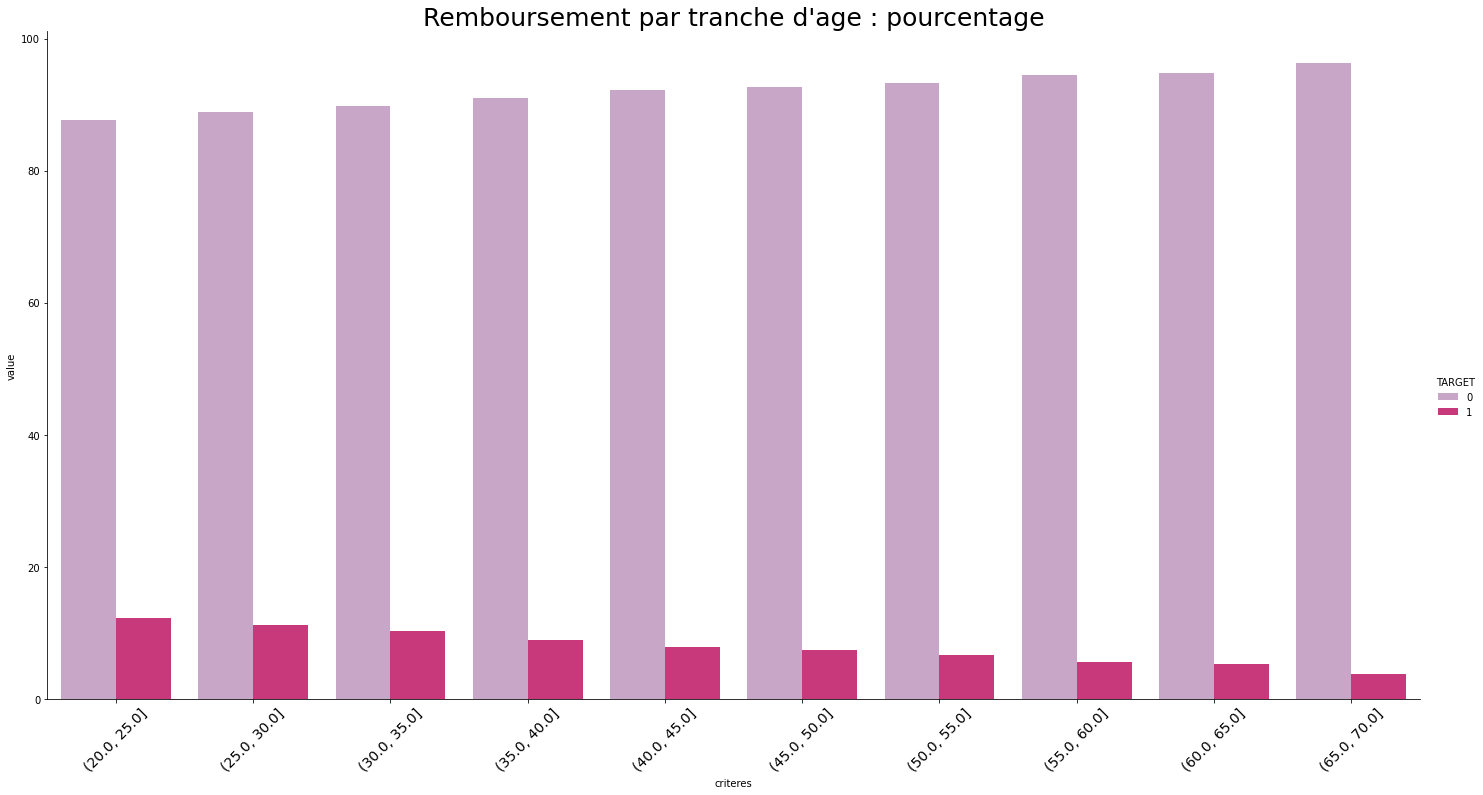

In [45]:
t = pd.crosstab([data_age['AGE_GROUP']], data_age['TARGET'], normalize = "index")
t = t.assign(criteres = t.index)
tm = pd.melt(t, id_vars="criteres")
tm = tm.assign(value = 100 * tm.value)
plt.figure(figsize=(10,0.9));
g = sns.catplot(x = "criteres", y = "value",hue = 'TARGET',  data = tm, palette='PuRd',
                   kind = "bar",height=10, aspect=2.);
g.set_xticklabels(rotation=45,fontsize = 14 );
plt.title("Remboursement par tranche d'age : pourcentage",fontsize=25);
plt.show();

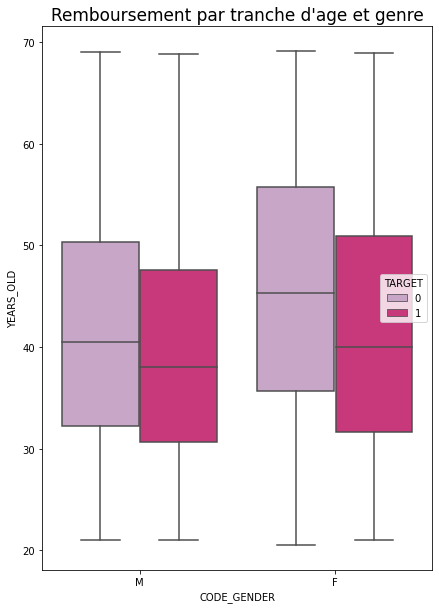

In [46]:
plt.figure(figsize=(7,10))
sns.boxplot(y = 'YEARS_OLD', x ='CODE_GENDER',hue = 'TARGET',palette = 'PuRd', data = data_age);
plt.title("Remboursement par tranche d'age et genre",fontsize=17);

#### Remboursement par et revenu par source de revenu

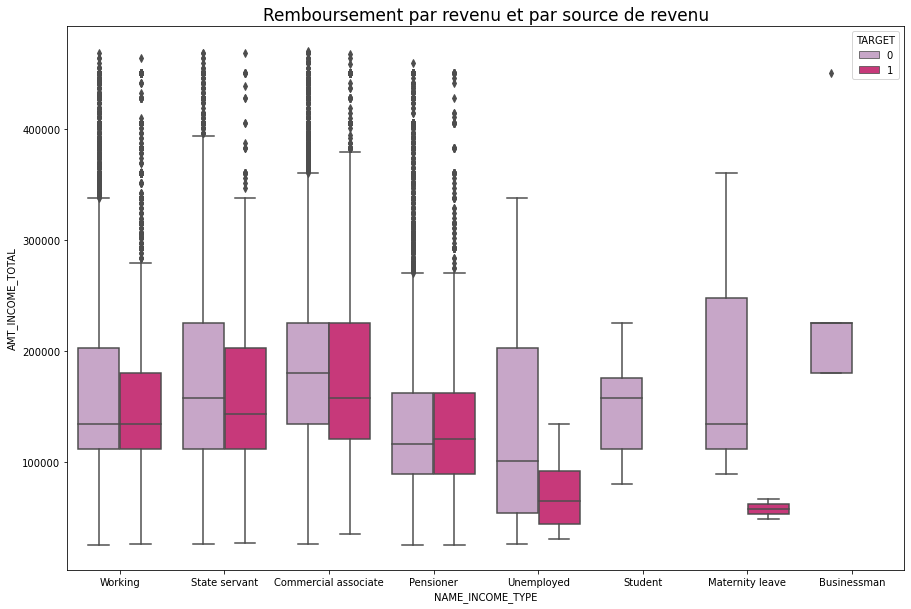

In [47]:
plt.figure(figsize=(15,10))
sns.boxplot(y = 'AMT_INCOME_TOTAL', x ='NAME_INCOME_TYPE',hue = 'TARGET',palette = 'PuRd', data = data_application_train[data_application_train['AMT_INCOME_TOTAL'] < 472500.0]);
plt.title("Remboursement par revenu et par source de revenu",fontsize=17);

### 1.2.2. Fichiers bureau 

In [48]:
data_bureau.shape

(1716428, 17)

In [49]:
data_bureau.isnull().sum()

SK_ID_CURR                      0
SK_ID_BUREAU                    0
CREDIT_ACTIVE                   0
CREDIT_CURRENCY                 0
DAYS_CREDIT                     0
CREDIT_DAY_OVERDUE              0
DAYS_CREDIT_ENDDATE        105553
DAYS_ENDDATE_FACT          633653
AMT_CREDIT_MAX_OVERDUE    1124488
CNT_CREDIT_PROLONG              0
AMT_CREDIT_SUM                 13
AMT_CREDIT_SUM_DEBT        257669
AMT_CREDIT_SUM_LIMIT       591780
AMT_CREDIT_SUM_OVERDUE          0
CREDIT_TYPE                     0
DAYS_CREDIT_UPDATE              0
AMT_ANNUITY               1226791
dtype: int64

In [50]:
data_bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [51]:
data_bureau.describe(include ='all')

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
count,1.716428e+06,1.716428e+06,1716428,1716428,1.716428e+06,1.716428e+06,1.610875e+06,1.082775e+06,5.919400e+05,1.716428e+06,1.716415e+06,1.458759e+06,1.124648e+06,1.716428e+06,1716428,1.716428e+06,4.896370e+05
unique,NaN,NaN,4,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15,NaN,NaN
top,NaN,NaN,Closed,currency 1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Consumer credit,NaN,NaN
freq,NaN,NaN,1079273,1715020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1251615,NaN,NaN
mean,2.782149e+05,5.924434e+06,NaN,NaN,-1.142108e+03,8.181666e-01,5.105174e+02,-1.017437e+03,3.825418e+03,6.410406e-03,3.549946e+05,1.370851e+05,6.229515e+03,3.791276e+01,NaN,-5.937483e+02,1.571276e+04
std,1.029386e+05,5.322657e+05,NaN,NaN,7.951649e+02,3.654443e+01,4.994220e+03,7.140106e+02,2.060316e+05,9.622391e-02,1.149811e+06,6.774011e+05,4.503203e+04,5.937650e+03,NaN,7.207473e+02,3.258269e+05
min,1.000010e+05,5.000000e+06,NaN,NaN,-2.922000e+03,0.000000e+00,-4.206000e+04,-4.202300e+04,0.000000e+00,0.000000e+00,0.000000e+00,-4.705600e+06,-5.864061e+05,0.000000e+00,NaN,-4.194700e+04,0.000000e+00
25%,1.888668e+05,5.463954e+06,NaN,NaN,-1.666000e+03,0.000000e+00,-1.138000e+03,-1.489000e+03,0.000000e+00,0.000000e+00,5.130000e+04,0.000000e+00,0.000000e+00,0.000000e+00,NaN,-9.080000e+02,0.000000e+00
50%,2.780550e+05,5.926304e+06,NaN,NaN,-9.870000e+02,0.000000e+00,-3.300000e+02,-8.970000e+02,0.000000e+00,0.000000e+00,1.255185e+05,0.000000e+00,0.000000e+00,0.000000e+00,NaN,-3.950000e+02,0.000000e+00
75%,3.674260e+05,6.385681e+06,NaN,NaN,-4.740000e+02,0.000000e+00,4.740000e+02,-4.250000e+02,0.000000e+00,0.000000e+00,3.150000e+05,4.015350e+04,0.000000e+00,0.000000e+00,NaN,-3.300000e+01,1.350000e+04


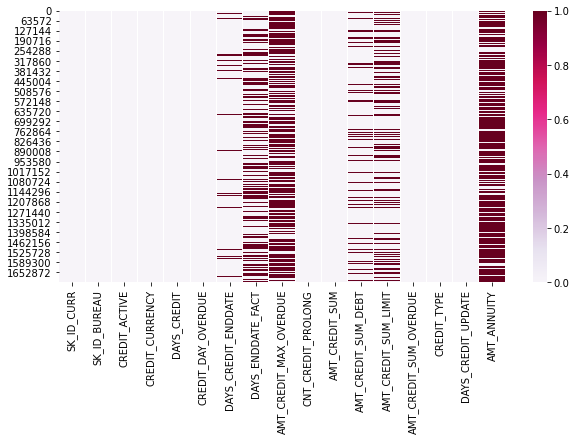

In [52]:
#Représentation graphique des données manquantes
plt.figure(figsize=(10,5))
sns.heatmap(data_bureau.isna(),cmap='PuRd');

In [53]:
total = data_bureau.isnull().sum().sort_values(ascending=False)
percent = (data_bureau.isnull().sum()/data_bureau.isnull().count()).sort_values(ascending=False)*100
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Pct %'])
missing_data[missing_data['Pct %']> 60.0]

,Total,Pct %
AMT_ANNUITY,1226791,71.473490
AMT_CREDIT_MAX_OVERDUE,1124488,65.513264


In [54]:
#Verification du nombre et pourcentage des valeurs manquantes
totalValeurs = data_bureau.size
num_nans = totalValeurs - data_bureau.count().sum()
pct = (num_nans/totalValeurs)*100
print(f"Pourcentage de valeurs manquantes: {pct:4.2f} %")

Pourcentage de valeurs manquantes: 13.50 %


In [55]:
data_bureau['CREDIT_ACTIVE'].value_counts()

Closed      1079273
Active       630607
Sold           6527
Bad debt         21
Name: CREDIT_ACTIVE, dtype: int64

In [56]:
data_bureau['CREDIT_CURRENCY'].value_counts()

currency 1    1715020
currency 2       1224
currency 3        174
currency 4         10
Name: CREDIT_CURRENCY, dtype: int64

In [57]:
#Vérification  des doublons
data_bureau.duplicated(subset=['SK_ID_BUREAU']).sum()

0

### 1.2.3. Fichiers  data_bureau_balance

In [58]:
data_bureau_balance.shape

(27299925, 3)

In [59]:
data_bureau_balance.isnull().sum()

SK_ID_BUREAU      0
MONTHS_BALANCE    0
STATUS            0
dtype: int64

In [60]:
data_bureau_balance.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


In [61]:
data_bureau_balance.describe(include ='all')

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
count,2.729992e+07,2.729992e+07,27299925
unique,NaN,NaN,8
top,NaN,NaN,C
freq,NaN,NaN,13646993
mean,6.036297e+06,-3.074169e+01,NaN
std,4.923489e+05,2.386451e+01,NaN
min,5.001709e+06,-9.600000e+01,NaN
25%,5.730933e+06,-4.600000e+01,NaN
50%,6.070821e+06,-2.500000e+01,NaN
75%,6.431951e+06,-1.100000e+01,NaN


In [62]:
total = data_bureau_balance.isnull().sum().sort_values(ascending=False)
percent = (data_bureau_balance.isnull().sum()/data_bureau_balance.isnull().count()).sort_values(ascending=False)*100
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Pct %'])
missing_data[missing_data['Pct %']> 60.0]

,Total,Pct %


In [63]:
#Verification du nombre et pourcentage des valeurs manquantes
totalValeurs = data_bureau_balance.size
num_nans = totalValeurs - data_bureau_balance.count().sum()
pct = (num_nans/totalValeurs)*100
print(f"Pourcentage de valeurs manquantes: {pct:4.2f} %")

Pourcentage de valeurs manquantes: 0.00 %


In [64]:
data_bureau_balance['STATUS'].value_counts()

C    13646993
0     7499507
X     5810482
1      242347
5       62406
2       23419
3        8924
4        5847
Name: STATUS, dtype: int64

Nous allons éliminer les valeurs de 'STATUS' à 'C'(canceled) et à 'X'(inconnue)

In [65]:
data_bureau_balance['DPD']= np.where((data_bureau_balance['STATUS']=='C') | (data_bureau_balance['STATUS']=='X'),np.nan,data_bureau_balance['STATUS'])

In [66]:
data_bureau_balance['DPD'] = data_bureau_balance['DPD'].astype(float)
data_bureau_balance.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS,DPD
0,5715448,0,C,NaN
1,5715448,-1,C,NaN
2,5715448,-2,C,NaN
3,5715448,-3,C,NaN
4,5715448,-4,C,NaN


In [67]:
data_bureau_balance_nb = data_bureau_balance.groupby('SK_ID_BUREAU').agg({'DPD' :'sum'})

In [68]:
data_bureau = data_bureau.merge(data_bureau_balance_nb, left_on = 'SK_ID_BUREAU', right_index = True, how = 'left')
data_bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY,DPD
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN,NaN


In [69]:
data_bureau['CREDIT_ACTIVE_BUREAU'] = np.where(data_bureau['CREDIT_ACTIVE'] == 'Active',1,0)

Nous avons ajouté une variable 'CREDIT_ACTIVE_BUREAU' afin de pouvoir calculer le nombre de crédit en cours

In [70]:
data_bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY,DPD,CREDIT_ACTIVE_BUREAU
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN,NaN,0
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN,NaN,1
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN,NaN,1
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN,NaN,1
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN,NaN,1


Agrégation des variables pertinentes par SK_ID_CURR en faisant la somme

In [71]:
data_bureau_cnt = data_bureau.groupby('SK_ID_CURR').agg({'SK_ID_CURR':'count','CREDIT_ACTIVE_BUREAU':'sum','DAYS_CREDIT_ENDDATE':'sum','DAYS_ENDDATE_FACT':'sum',
                                                         'CREDIT_DAY_OVERDUE':'sum','AMT_CREDIT_SUM':'sum',
                                                         'CNT_CREDIT_PROLONG':'sum','AMT_CREDIT_SUM_OVERDUE':'sum','DPD':'sum'}).rename(columns={'SK_ID_CURR': 'NB_CREDIT_BUREAU','DPD':'DPD_BR'})
data_bureau_cnt.head()

,NB_CREDIT_BUREAU,CREDIT_ACTIVE_BUREAU,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,CREDIT_DAY_OVERDUE,AMT_CREDIT_SUM,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM_OVERDUE,DPD_BR
SK_ID_CURR,,,,,,,,,
100001,7,3,577.0,-3302.0,0,1453365.000,0,0.0,1.0
100002,8,2,-2094.0,-4185.0,0,865055.565,0,0.0,27.0
100003,4,1,-2178.0,-3292.0,0,1017400.500,0,0.0,0.0
100004,2,0,-977.0,-1065.0,0,189037.800,0,0.0,0.0
100005,3,2,1318.0,-123.0,0,657126.000,0,0.0,0.0


### 1.2.4. Fichier previous_application

In [72]:
previous_application.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,Y,1,0.0,0.182832,0.867336,XAP,Approved,-73,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,NaN,Country-wide,35,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,Y,1,NaN,NaN,NaN,NaN,Approved,-164,NaN,XAP,Unaccompanied,Repeater,NaN,Cash,x-sell,Contact center,-1,NaN,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,Y,1,NaN,NaN,NaN,NaN,Approved,-301,Cash through the bank,XAP,"Spouse, partner",Repeater,NaN,Cash,x-sell,Credit and cash offices,-1,NaN,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,Y,1,NaN,NaN,NaN,NaN,Approved,-512,Cash through the bank,XAP,NaN,Repeater,NaN,Cash,x-sell,Credit and cash offices,-1,NaN,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,Y,1,NaN,NaN,NaN,Repairs,Refused,-781,Cash through the bank,HC,NaN,Repeater,NaN,Cash,walk-in,Credit and cash offices,-1,NaN,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


In [73]:
previous_application.describe(include ='all')

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
count,1.670214e+06,1.670214e+06,1669868,1.297979e+06,1.670214e+06,1.670213e+06,7.743700e+05,1.284699e+06,1670214,1.670214e+06,1670214,1.670214e+06,774370.000000,5951.000000,5951.000000,992296,1670214,1.670214e+06,1042830,1664970,849809,1668273,719405,1297984,606548,1670214,1.670214e+06,814494,1.297984e+06,1152999,1669868,997149.000000,997149.000000,997149.000000,997149.000000,997149.000000,997149.000000
unique,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN,7,NaN,2,NaN,NaN,NaN,NaN,24,4,NaN,3,8,7,3,27,4,2,8,NaN,10,NaN,4,17,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,Cash loans,NaN,NaN,NaN,NaN,NaN,TUESDAY,NaN,Y,NaN,NaN,NaN,NaN,XAP,Approved,NaN,Cash through the bank,XAP,Unaccompanied,Repeater,Mobile,POS,x-sell,Credit and cash offices,NaN,Consumer electronics,NaN,middle,Cash,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,747553,NaN,NaN,NaN,NaN,NaN,255118,NaN,1661739,NaN,NaN,NaN,NaN,922661,1036781,NaN,1033552,1353093,508970,1231261,224708,691011,456287,719968,NaN,398265,NaN,385532,285990,NaN,NaN,NaN,NaN,NaN,NaN
mean,1.923089e+06,2.783572e+05,NaN,1.595512e+04,1.752339e+05,1.961140e+05,6.697402e+03,2.278473e+05,NaN,1.248418e+01,NaN,9.964675e-01,0.079637,0.188357,0.773503,NaN,NaN,-8.806797e+02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.139511e+02,NaN,1.605408e+01,NaN,NaN,342209.855039,13826.269337,33767.774054,76582.403064,81992.343838,0.332570
std,5.325980e+05,1.028148e+05,NaN,1.478214e+04,2.927798e+05,3.185746e+05,2.092150e+04,3.153966e+05,NaN,3.334028e+00,NaN,5.932963e-02,0.107823,0.087671,0.100879,NaN,NaN,7.790997e+02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.127443e+03,NaN,1.456729e+01,NaN,NaN,88916.115834,72444.869708,106857.034789,149647.415123,153303.516729,0.471134
min,1.000001e+06,1.000010e+05,NaN,0.000000e+00,0.000000e+00,0.000000e+00,-9.000000e-01,0.000000e+00,NaN,0.000000e+00,NaN,0.000000e+00,-0.000015,0.034781,0.373150,NaN,NaN,-2.922000e+03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.000000e+00,NaN,0.000000e+00,NaN,NaN,-2922.000000,-2892.000000,-2801.000000,-2889.000000,-2874.000000,0.000000
25%,1.461857e+06,1.893290e+05,NaN,6.321780e+03,1.872000e+04,2.416050e+04,0.000000e+00,5.084100e+04,NaN,1.000000e+01,NaN,1.000000e+00,0.000000,0.160716,0.715645,NaN,NaN,-1.300000e+03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.000000e+00,NaN,6.000000e+00,NaN,NaN,365243.000000,-1628.000000,-1242.000000,-1314.000000,-1270.000000,0.000000
50%,1.923110e+06,2.787145e+05,NaN,1.125000e+04,7.104600e+04,8.054100e+04,1.638000e+03,1.123200e+05,NaN,1.200000e+01,NaN,1.000000e+00,0.051605,0.189122,0.835095,NaN,NaN,-5.810000e+02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.000000e+00,NaN,1.200000e+01,NaN,NaN,365243.000000,-831.000000,-361.000000,-537.000000,-499.000000,0.000000
75%,2.384280e+06,3.675140e+05,NaN,2.065842e+04,1.803600e+05,2.164185e+05,7.740000e+03,2.340000e+05,NaN,1.500000e+01,NaN,1.000000e+00,0.108909,0.193330,0.852537,NaN,NaN,-2.800000e+02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.200000e+01,NaN,2.400000e+01,NaN,NaN,365243.000000,-411.000000,129.000000,-74.000000,-44.000000,1.000000


In [74]:
previous_application.shape

(1670214, 37)

In [75]:
total = previous_application.isnull().sum().sort_values(ascending=False)
percent = (previous_application.isnull().sum()/previous_application.isnull().count()).sort_values(ascending=False)*100
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Pct %'])
missing_data[missing_data['Pct %']> 60.0]

,Total,Pct %
RATE_INTEREST_PRIMARY,1664263,99.643698
RATE_INTEREST_PRIVILEGED,1664263,99.643698
NAME_PRODUCT_TYPE,1063666,63.684414


In [76]:
#Verification du nombre et pourcentage des valeurs manquantes
totalValeurs = previous_application.size
num_nans = totalValeurs - previous_application.count().sum()
pct = (num_nans/totalValeurs)*100
print(f"Pourcentage de valeurs manquantes: {pct:4.2f} %")

Pourcentage de valeurs manquantes: 26.19 %


In [77]:
previous_application['NAME_CONTRACT_STATUS'].value_counts()

Approved        1036781
Canceled         316319
Refused          290678
Unused offer      26436
Name: NAME_CONTRACT_STATUS, dtype: int64

### 1.2.5. Fichier POS_CASH_balance

In [78]:
pos_cash_balance.shape

(10001358, 8)

In [79]:
pos_cash_balance.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


In [80]:
pos_cash_balance.describe(include ='all')

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
count,1.000136e+07,1.000136e+07,1.000136e+07,9.975287e+06,9.975271e+06,10001356,1.000136e+07,1.000136e+07
unique,NaN,NaN,NaN,NaN,NaN,8,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,Active,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,9151119,NaN,NaN
mean,1.903217e+06,2.784039e+05,-3.501259e+01,1.708965e+01,1.048384e+01,NaN,1.160693e+01,6.544684e-01
std,5.358465e+05,1.027637e+05,2.606657e+01,1.199506e+01,1.110906e+01,NaN,1.327140e+02,3.276249e+01
min,1.000001e+06,1.000010e+05,-9.600000e+01,1.000000e+00,0.000000e+00,NaN,0.000000e+00,0.000000e+00
25%,1.434405e+06,1.895500e+05,-5.400000e+01,1.000000e+01,3.000000e+00,NaN,0.000000e+00,0.000000e+00
50%,1.896565e+06,2.786540e+05,-2.800000e+01,1.200000e+01,7.000000e+00,NaN,0.000000e+00,0.000000e+00
75%,2.368963e+06,3.674290e+05,-1.300000e+01,2.400000e+01,1.400000e+01,NaN,0.000000e+00,0.000000e+00


In [81]:
#valeurs absentes
total = pos_cash_balance.isnull().sum().sort_values(ascending=False)
percent = (pos_cash_balance.isnull().sum()/pos_cash_balance.isnull().count()).sort_values(ascending=False)*100
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Pct %'])
missing_data[missing_data['Pct %']> 60.0]

,Total,Pct %


In [82]:
#Verification du nombre et pourcentage des valeurs manquantes
totalValeurs = pos_cash_balance.size
num_nans = totalValeurs - pos_cash_balance.count().sum()
pct = (num_nans/totalValeurs)*100
print(f"Pourcentage de valeurs manquantes: {pct:4.2f} %")

Pourcentage de valeurs manquantes: 0.07 %


In [83]:
pos_cash_balance['NAME_CONTRACT_STATUS'].value_counts()

Active                   9151119
Completed                 744883
Signed                     87260
Demand                      7065
Returned to the store       5461
Approved                    4917
Amortized debt               636
Canceled                      15
Name: NAME_CONTRACT_STATUS, dtype: int64

Agrégation des variables pertinentes pour les lignes actives par SK_ID_CURR en faisant la somme

In [84]:
pos_cash_balance_cnt = pos_cash_balance[pos_cash_balance['NAME_CONTRACT_STATUS']=='Active'].groupby(['SK_ID_CURR','SK_ID_PREV']).agg({'NAME_CONTRACT_STATUS':'count','SK_DPD':'sum','SK_DPD_DEF':'sum'}).rename(columns={'NAME_CONTRACT_STATUS': 'NB_CASH','SK_DPD':'SK_DPD_CASH','SK_DPD_DEF':'SK_DPD_DEF_CASH'})
pos_cash_balance_cnt.head()

NB_CASH  SK_DPD_CASH  SK_DPD_DEF_CASH
SK_ID_CURR SK_ID_PREV                                       
100001     1369693           4            0                0
           1851984           3            7                7
100002     1038818          19            0                0
100003     1810518           7            0                0
           2396755          12            0                0

### 1.2.6. Fichier Installment_payments

In [85]:

installments_payments.head()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585


In [86]:
installments_payments.shape

(13605401, 8)

In [87]:
#valeurs absentes
total = installments_payments.isnull().sum().sort_values(ascending=False)
percent = (installments_payments.isnull().sum()/installments_payments.isnull().count()).sort_values(ascending=False)*100
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Pct %'])
missing_data[missing_data['Pct %']> 60.0]

,Total,Pct %


In [88]:
#Verification du nombre et pourcentage des valeurs manquantes
totalValeurs = installments_payments.size
num_nans = totalValeurs - installments_payments.count().sum()
pct = (num_nans/totalValeurs)*100
print(f"Pourcentage de valeurs manquantes: {pct:4.2f} %")

Pourcentage de valeurs manquantes: 0.01 %


Nous avons pris uniquement les lignes avec le retard de payement:

In [89]:
installments_payments['DIFF_DAY_PAYMENT'] = abs(installments_payments['DAYS_INSTALMENT'])- abs(installments_payments['DAYS_ENTRY_PAYMENT'])

In [90]:
installments_payments['DIFF_AMOUNT_PAYMENT'] = installments_payments['AMT_PAYMENT']- installments_payments['AMT_INSTALMENT']

In [91]:
installments_payments[(installments_payments['DIFF_AMOUNT_PAYMENT'] < 0)|(installments_payments['DIFF_DAY_PAYMENT'] < 0)]

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT,DIFF_DAY_PAYMENT,DIFF_AMOUNT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360,-7.0,0.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130,-8.0,0.000
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585,17.0,-4.455
5,1137312,164489,1.0,12,-1384.0,-1417.0,5970.375,5970.375,-33.0,0.000
6,2234264,184693,4.0,11,-349.0,-352.0,29432.295,29432.295,-3.0,0.000
...,...,...,...,...,...,...,...,...,...,...
13605341,2149043,415032,0.0,9,-425.0,-434.0,46517.490,46517.490,-9.0,0.000
13605342,1374521,419603,0.0,8,-1177.0,-1184.0,4869.315,4869.315,-7.0,0.000
13605344,2006721,442291,1.0,3,-1311.0,-1318.0,2934.225,2934.225,-7.0,0.000
13605345,1126000,428449,0.0,12,-301.0,-302.0,6793.470,6750.000,-1.0,-43.470


Agrégation des variables pertinentes pour les lignes en retard du payement par SK_ID_CURR en faisant la somme

In [92]:
installments_payments_retard_cnt = installments_payments[(installments_payments['DIFF_AMOUNT_PAYMENT'] < 0)|(installments_payments['DIFF_DAY_PAYMENT'] < 0)].groupby(['SK_ID_CURR','SK_ID_PREV']).agg({'NUM_INSTALMENT_NUMBER':'count',
                                                         'DIFF_DAY_PAYMENT':'sum','DIFF_AMOUNT_PAYMENT':'sum'}).rename(columns={'NUM_INSTALMENT_NUMBER': 'NB_RETARD_PAYMENT'})
installments_payments_retard_cnt.head()

NB_RETARD_PAYMENT  DIFF_DAY_PAYMENT  \
SK_ID_CURR SK_ID_PREV                                        
100001     1369693                     4             -62.0   
100002     1038818                    19            -388.0   
100003     1810518                     7             -31.0   
           2396755                    12             -81.0   
           2636178                     6             -67.0   

                       DIFF_AMOUNT_PAYMENT  
SK_ID_CURR SK_ID_PREV                       
100001     1369693                     0.0  
100002     1038818                     0.0  
100003     1810518                     0.0  
           2396755                     0.0  
           2636178                     0.0

### 1.2.7. Fichier credit_card_balance

In [93]:
credit_card_balance.shape

(3840312, 23)

In [94]:
credit_card_balance.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,1800.0,1800.0,0.000,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,2250.0,2250.0,60175.080,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,2250.0,2250.0,26926.425,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,11925.0,11925.0,224949.285,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,27000.0,27000.0,443044.395,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0


In [95]:
credit_card_balance.describe(include='all')

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
count,3.840312e+06,3.840312e+06,3.840312e+06,3.840312e+06,3.840312e+06,3.090496e+06,3.840312e+06,3.090496e+06,3.090496e+06,3.535076e+06,3.072324e+06,3.840312e+06,3.840312e+06,3.840312e+06,3.840312e+06,3.090496e+06,3.840312e+06,3.090496e+06,3.090496e+06,3.535076e+06,3840312,3.840312e+06,3.840312e+06
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Active,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3698436,NaN,NaN
mean,1.904504e+06,2.783242e+05,-3.452192e+01,5.830016e+04,1.538080e+05,5.961325e+03,7.433388e+03,2.881696e+02,2.968805e+03,3.540204e+03,1.028054e+04,7.588857e+03,5.596588e+04,5.808881e+04,5.809829e+04,3.094490e-01,7.031439e-01,4.812496e-03,5.594791e-01,2.082508e+01,NaN,9.283667e+00,3.316220e-01
std,5.364695e+05,1.027045e+05,2.666775e+01,1.063070e+05,1.651457e+05,2.822569e+04,3.384608e+04,8.201989e+03,2.079689e+04,5.600154e+03,3.607808e+04,3.200599e+04,1.025336e+05,1.059654e+05,1.059718e+05,1.100401e+00,3.190347e+00,8.263861e-02,3.240649e+00,2.005149e+01,NaN,9.751570e+01,2.147923e+01
min,1.000018e+06,1.000060e+05,-9.600000e+01,-4.202502e+05,0.000000e+00,-6.827310e+03,-6.211620e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-4.233058e+05,-4.202502e+05,-4.202502e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,0.000000e+00,0.000000e+00
25%,1.434385e+06,1.895170e+05,-5.500000e+01,0.000000e+00,4.500000e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.523700e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00,NaN,0.000000e+00,0.000000e+00
50%,1.897122e+06,2.783960e+05,-2.800000e+01,0.000000e+00,1.125000e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.702700e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.500000e+01,NaN,0.000000e+00,0.000000e+00
75%,2.369328e+06,3.675800e+05,-1.100000e+01,8.904669e+04,1.800000e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.633911e+03,9.000000e+03,6.750000e+03,8.535924e+04,8.889949e+04,8.891451e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.200000e+01,NaN,0.000000e+00,0.000000e+00


In [96]:
#valeurs absentes
total = credit_card_balance.isnull().sum().sort_values(ascending=False)
percent = (credit_card_balance.isnull().sum()/credit_card_balance.isnull().count()).sort_values(ascending=False)*100
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Pct %'])
missing_data[missing_data['Pct %']> 60.0]

,Total,Pct %


In [97]:
#Verification du nombre et pourcentage des valeurs manquantes
totalValeurs = credit_card_balance.size
num_nans = totalValeurs - credit_card_balance.count().sum()
pct = (num_nans/totalValeurs)*100
print(f"Pourcentage de valeurs manquantes: {pct:4.2f} %")

Pourcentage de valeurs manquantes: 6.65 %


In [98]:
# nombre de chaque type de colonne
credit_card_balance.dtypes.value_counts()

float64    15
int64       7
object      1
dtype: int64

In [99]:
# nombre de chaque type de colonne
credit_card_balance['NAME_CONTRACT_STATUS'].value_counts()

Active           3698436
Completed         128918
Signed             11058
Demand              1365
Sent proposal        513
Refused               17
Approved               5
Name: NAME_CONTRACT_STATUS, dtype: int64

Nous avons gardé uniquement les lignes avec une balance négative pour les lignes en statut 'Active' et 'Completed'

In [100]:
credit_card_balance_dec_nb = credit_card_balance[(credit_card_balance['NAME_CONTRACT_STATUS'].isin(['Active','Completed'])) & (credit_card_balance['AMT_BALANCE'] < 0)].groupby(['SK_ID_CURR','SK_ID_PREV']).agg({'MONTHS_BALANCE':'count','AMT_BALANCE':'sum','SK_DPD':'sum','SK_DPD_DEF':'sum'}).rename(columns={'MONTHS_BALANCE': 'NB_BALANCE_NEGATIVE','SK_DPD_DEF':'SK_DPD_DEF_CREDIT_CARD','SK_DPD':'SK_DPD_CREDIT_CARD'})
credit_card_balance_dec_nb.head()


,,NB_BALANCE_NEGATIVE,AMT_BALANCE,SK_DPD_CREDIT_CARD,SK_DPD_DEF_CREDIT_CARD
SK_ID_CURR,SK_ID_PREV,,,,
100116,2775966,2,-1199.970,0,0
100148,2570338,3,-965.115,0,0
100461,1956380,1,-22.320,0,0
100621,1410600,3,-216.090,0,0
100749,1622722,3,-2075.490,0,0


## 1.3. Merge des fichiers

#### DataFrame application + data_bureau

In [101]:
df = df.merge(data_bureau_cnt, left_on = 'SK_ID_CURR', right_index = True, how = 'left',validate="one_to_many")
df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NB_CREDIT_BUREAU,CREDIT_ACTIVE_BUREAU,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,CREDIT_DAY_OVERDUE,AMT_CREDIT_SUM,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM_OVERDUE,DPD_BR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,8.0,2.0,-2094.0,-4185.0,0.0,865055.565,0.0,0.0,27.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,-2178.0,-3292.0,0.0,1017400.500,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,Ho

In [102]:
#df.iloc[:,-7:-1].fillna(value = 0,inplace=True)
df.update(df.iloc[:,-7:].fillna(0))

In [103]:
df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NB_CREDIT_BUREAU,CREDIT_ACTIVE_BUREAU,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,CREDIT_DAY_OVERDUE,AMT_CREDIT_SUM,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM_OVERDUE,DPD_BR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,8.0,2.0,-2094.0,-4185.0,0.0,865055.565,0.0,0.0,27.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,-2178.0,-3292.0,0.0,1017400.500,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,Ho

####  previous_application +  POS_CASH_balance, installments_payments_retard_cnt, credit_card_balance_dec_nb

In [104]:
print('Nombre colonne à ajouter  :',(pos_cash_balance_cnt.shape[1]) + (installments_payments_retard_cnt.shape[1]) + (credit_card_balance_dec_nb.shape[1]))

Nombre colonne à ajouter  : 10


In [105]:
previous_application = previous_application.merge(pos_cash_balance_cnt, left_on = ['SK_ID_CURR','SK_ID_PREV'], right_index = True, how = 'left')
previous_application = previous_application.merge(installments_payments_retard_cnt, left_on = ['SK_ID_CURR','SK_ID_PREV'], right_index = True, how = 'left')
previous_application = previous_application.merge(credit_card_balance_dec_nb, left_on = ['SK_ID_CURR','SK_ID_PREV'], right_index = True, how = 'left')
previous_application.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL,NB_CASH,SK_DPD_CASH,SK_DPD_DEF_CASH,NB_RETARD_PAYMENT,DIFF_DAY_PAYMENT,DIFF_AMOUNT_PAYMENT,NB_BALANCE_NEGATIVE,AMT_BALANCE,SK_DPD_CREDIT_CARD,SK_DPD_DEF_CREDIT_CARD
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,Y,1,0.0,0.182832,0.867336,XAP,Approved,-73,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,NaN,Country-wide,35,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,Y,1,NaN,NaN,NaN,NaN,Approved,-164,NaN,XAP,Unaccompanied,Repeater,NaN,Cash,x-sell,Contact center,-1,NaN,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0,5.0,0.0,0.0,5.0,-46.0,0.0,NaN,NaN,NaN,NaN
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,Y,1,NaN,NaN,NaN,NaN,Approved,-301,Cash through the bank,XAP,"Spouse, partner",Repeater,NaN,Cash,x-sell,Credit and cash offices,-1,NaN,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0,10.0,0.0,0.0,8.0,-75.0,0.0,NaN,NaN,NaN,NaN
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,Y,1,NaN,NaN,NaN,NaN,Approved,-512,Cash through the bank,XAP,NaN,Repeater,NaN,Cash,x-sell,Credit and cash offices,-1,NaN,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0,11.0,0.0,0.0,10.0,-78.0,0.0,NaN,NaN,NaN,NaN
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,Y,1,NaN,NaN,NaN,Repairs,Refused,-781,Cash through the bank,HC,NaN,Repeater,NaN,Cash,walk-in,Credit and cash offices,-1,NaN,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [106]:
previous_application.update(previous_application.iloc[:,-12:].fillna(0))

In [107]:
previous_application.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL,NB_CASH,SK_DPD_CASH,SK_DPD_DEF_CASH,NB_RETARD_PAYMENT,DIFF_DAY_PAYMENT,DIFF_AMOUNT_PAYMENT,NB_BALANCE_NEGATIVE,AMT_BALANCE,SK_DPD_CREDIT_CARD,SK_DPD_DEF_CREDIT_CARD
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,Y,1,0.0,0.182832,0.867336,XAP,Approved,-73,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,NaN,Country-wide,35,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,Y,1,NaN,NaN,NaN,NaN,Approved,-164,NaN,XAP,Unaccompanied,Repeater,NaN,Cash,x-sell,Contact center,-1,NaN,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0,5.0,0.0,0.0,5.0,-46.0,0.0,0.0,0.0,0.0,0.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,Y,1,NaN,NaN,NaN,NaN,Approved,-301,Cash through the bank,XAP,"Spouse, partner",Repeater,NaN,Cash,x-sell,Credit and cash offices,-1,NaN,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0,10.0,0.0,0.0,8.0,-75.0,0.0,0.0,0.0,0.0,0.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,Y,1,NaN,NaN,NaN,NaN,Approved,-512,Cash through the bank,XAP,NaN,Repeater,NaN,Cash,x-sell,Credit and cash offices,-1,NaN,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0,11.0,0.0,0.0,10.0,-78.0,0.0,0.0,0.0,0.0,0.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,Y,1,NaN,NaN,NaN,Repairs,Refused,-781,Cash through the bank,HC,NaN,Repeater,NaN,Cash,walk-in,Credit and cash offices,-1,NaN,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Création une nouvelles variables 'CREDIT_EN_COURS_APP': le nombre de crédit en cours dans l'établissement

In [108]:
previous_application['CREDIT_EN_COURS_APP'] = np.where(previous_application['NAME_CONTRACT_STATUS'] == 'Approved',0,1)

Création une nouvelles variables 'CREDIT_REFUSED_APP': le nombre de crédit refusé par l'établissement

In [109]:
previous_application['CREDIT_REFUSED_APP'] = np.where(previous_application['NAME_CONTRACT_STATUS'] == 'Refused',0,1)

In [110]:
previous_application_nb = previous_application.groupby(['SK_ID_CURR']).agg({'NAME_CONTRACT_TYPE':'count','AMT_CREDIT':'sum','AMT_APPLICATION':'sum',
                                                        'SK_DPD_CREDIT_CARD':'sum','SK_DPD_DEF_CREDIT_CARD':'sum','NB_RETARD_PAYMENT':'sum','DIFF_DAY_PAYMENT':'sum',
                                                        'DIFF_AMOUNT_PAYMENT':'sum', 'NB_BALANCE_NEGATIVE':'sum', 'AMT_BALANCE':'sum','NB_CASH':'sum','CREDIT_EN_COURS_APP':'sum',
                                                        'SK_DPD_CASH':'sum','SK_DPD_DEF_CASH':'sum','CREDIT_REFUSED_APP':'sum'}).rename(columns={'NAME_CONTRACT_TYPE': 'NB_PREVIOUS_APP',
                                                                                                                                   'AMT_CREDIT':'AMT_CREDIT_PREVIOUS_APP' })
previous_application_nb.head()


,NB_PREVIOUS_APP,AMT_CREDIT_PREVIOUS_APP,AMT_APPLICATION,SK_DPD_CREDIT_CARD,SK_DPD_DEF_CREDIT_CARD,NB_RETARD_PAYMENT,DIFF_DAY_PAYMENT,DIFF_AMOUNT_PAYMENT,NB_BALANCE_NEGATIVE,AMT_BALANCE,NB_CASH,CREDIT_EN_COURS_APP,SK_DPD_CASH,SK_DPD_DEF_CASH,CREDIT_REFUSED_APP
SK_ID_CURR,,,,,,,,,,,,,,,
100001,1,23787.0,24835.5,0.0,0.0,4.0,-62.0,0.0,0.0,0.0,4.0,0,0.0,0.0,1
100002,1,179055.0,179055.0,0.0,0.0,19.0,-388.0,0.0,0.0,0.0,19.0,0,0.0,0.0,1
100003,3,1452573.0,1306309.5,0.0,0.0,25.0,-179.0,0.0,0.0,0.0,26.0,0,0.0,0.0,3
100004,1,20106.0,24282.0,0.0,0.0,3.0,-23.0,0.0,0.0,0.0,3.0,0,0.0,0.0,1
100005,2,40153.5,44617.5,0.0,0.0,8.0,-213.0,0.0,0.0,0.0,9.0,1,0.0,0.0,2


#### DataFrame application + previous_application

In [111]:
print('Nombre colonne à ajouter  :',previous_application_nb.shape[1])

Nombre colonne à ajouter  : 15


In [112]:
df = df.merge(previous_application_nb, left_on = 'SK_ID_CURR', right_index = True, how = 'left',validate="one_to_many")
df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NB_CREDIT_BUREAU,CREDIT_ACTIVE_BUREAU,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,CREDIT_DAY_OVERDUE,AMT_CREDIT_SUM,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM_OVERDUE,DPD_BR,NB_PREVIOUS_APP,AMT_CREDIT_PREVIOUS_APP,AMT_APPLICATION,SK_DPD_CREDIT_CARD,SK_DPD_DEF_CREDIT_CARD,NB_RETARD_PAYMENT,DIFF_DAY_PAYMENT,DIFF_AMOUNT_PAYMENT,NB_BALANCE_NEGATIVE,AMT_BALANCE,NB_CASH,CREDIT_EN_COURS_APP,SK_DPD_CASH,SK_DPD_DEF_CASH,CREDIT_REFUSED_APP
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,8.0,2.0,-2094.0,-4185.0,0.0,865055.565,0.0,0.0,27.0,1.0,179055.0,179055.00,0.0,0.0,19.0,-388.0,0.000,0.0,0.0,19.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.00

In [113]:
df.update(df.iloc[:,-12:].fillna(0))

Création une nouvelles variables 'CREDIT_TERM': la duréé de crédit

In [114]:
df['CREDIT_TERM'] = df['AMT_ANNUITY']/df['AMT_CREDIT']

In [115]:
df['NB_CREDIT_ACTIFS']= df['CREDIT_ACTIVE_BUREAU']+ df['CREDIT_EN_COURS_APP']

In [116]:
df.describe(include='all')

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NB_CREDIT_BUREAU,CREDIT_ACTIVE_BUREAU,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,CREDIT_DAY_OVERDUE,AMT_CREDIT_SUM,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM_OVERDUE,DPD_BR,NB_PREVIOUS_APP,AMT_CREDIT_PREVIOUS_APP,AMT_APPLICATION,SK_DPD_CREDIT_CARD,SK_DPD_DEF_CREDIT_CARD,NB_RETARD_PAYMENT,DIFF_DAY_PAYMENT,DIFF_AMOUNT_PAYMENT,NB_BALANCE_NEGATIVE,AMT_BALANCE,NB_CASH,CREDIT_EN_COURS_APP,SK_DPD_CASH,SK_DPD_DEF_CASH,CREDIT_REFUSED_APP,CREDIT_TERM,NB_CREDIT_ACTIFS
count,307511.000000,307511.000000,307511,307507,307511,307511,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,306219,307511,307511,307509,307511,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,104582.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,211120,307509.000000,307511.000000,307511.000000,307511,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,252137,134133.000000,3.068510e+05,246546.000000,151450.00000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,151450.000000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,151450.000000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,97216,153214,159080.000000,151170,161756,306490.000000,306490.000000,306490.000000,306490.000000,307510.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,3075

#### Correlations les plus importantes avec la variable TARGET après la merge

In [117]:
#On cherche les correlations les plus importantes
correlations = df.corr()['TARGET'].sort_values()
# Display correlations
print('Correlations positives:\n', correlations.tail(15))
print('\nCorrelations negatives :\n', correlations.head(15))

Correlations positives:
 REG_CITY_NOT_LIVE_CITY         0.044395
FLAG_EMP_PHONE                 0.045982
DAYS_CREDIT_ENDDATE            0.046238
REG_CITY_NOT_WORK_CITY         0.050994
DAYS_ID_PUBLISH                0.051457
DAYS_ENDDATE_FACT              0.051777
CREDIT_EN_COURS_APP            0.052498
DAYS_LAST_PHONE_CHANGE         0.055218
REGION_RATING_CLIENT           0.058899
REGION_RATING_CLIENT_W_CITY    0.060893
CREDIT_ACTIVE_BUREAU           0.067128
NB_CREDIT_ACTIFS               0.077225
DAYS_BIRTH                     0.078239
TARGET                         1.000000
SK_DPD_DEF_CREDIT_CARD              NaN
Name: TARGET, dtype: float64

Correlations negatives :
 EXT_SOURCE_3                 -0.178919
EXT_SOURCE_2                 -0.160472
EXT_SOURCE_1                 -0.155317
DAYS_EMPLOYED                -0.044932
FLOORSMAX_AVG                -0.044003
FLOORSMAX_MEDI               -0.043768
FLOORSMAX_MODE               -0.043226
AMT_GOODS_PRICE              -0.039645
REGION_

### 1.4. Identification des facteurs de risque

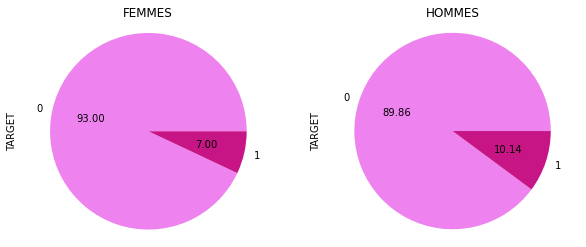

In [118]:
plt.figure(figsize=(10,4))
plt.figure(1)
plt.subplot(1, 2, 1)
df[df['CODE_GENDER']== 'F']['TARGET'].value_counts(normalize=True).plot(kind='pie',autopct='%.2f',colors = ['violet', 'mediumvioletred'])
plt.axis('equal')
plt.title('FEMMES')
plt.subplot(1, 2, 2)                                                           
df_m = df[df['CODE_GENDER']== 'M']['TARGET'].value_counts(normalize=True).plot(kind='pie',autopct='%.2f',colors = ['violet', 'mediumvioletred'])
plt.axis('equal')
plt.title('HOMMES')
plt.show()                                                             


Nous avons constaté également que Data set contient 66% de femmes. Cependant 10% d'hommes ne remboursent pas le crédit contre 7% de femmes.

<Figure size 1080x1080 with 0 Axes>

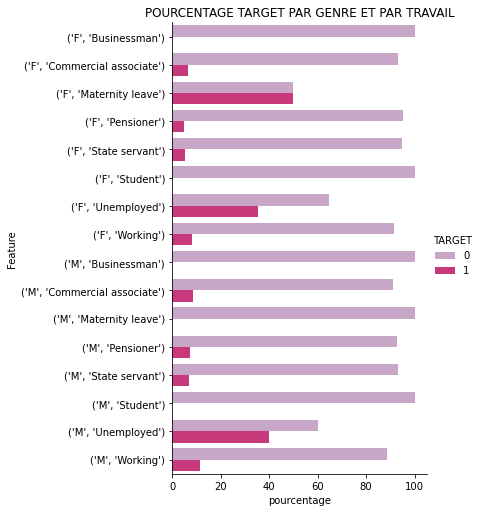

In [119]:
t = pd.crosstab([data_application_train['CODE_GENDER'], data_application_train['NAME_INCOME_TYPE']], data_application_train['TARGET'], normalize = "index")
t = t.assign(Feature = t.index)
tm = pd.melt(t, id_vars="Feature")
tm = tm.assign(pourcentage = 100 * tm.value)
plt.figure(figsize=(15,15))
g = sns.catplot(x = "pourcentage", y = "Feature" , hue = 'TARGET', data = tm, palette='PuRd',
                   kind = "bar",height=7, aspect=.9)
plt.title('POURCENTAGE TARGET PAR GENRE ET PAR TRAVAIL')
plt.show()

Nous constatons queles personnes sans emploi ont le pourcentage le plus élevé de non remboursement

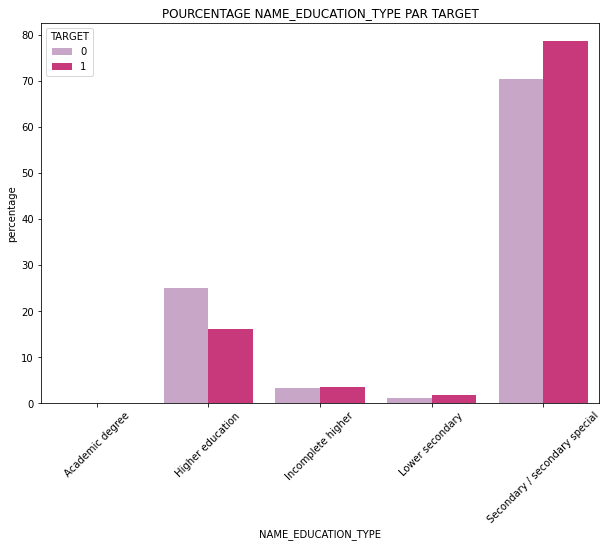

In [120]:
plot_pourcentage(df,'TARGET','NAME_EDUCATION_TYPE')

Les clients avec le niveau d'éducation 'Secondary' ont le pourcentage de non remboursement le plus élevé

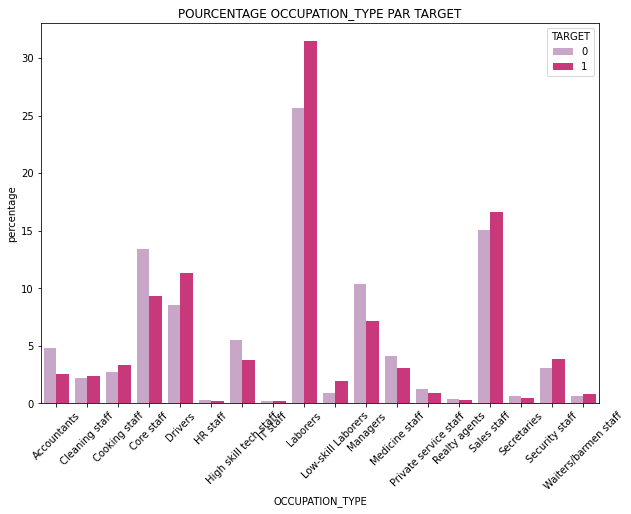

In [121]:
plot_pourcentage(df,'TARGET','OCCUPATION_TYPE')

Les ouvriers(Laborer) ont le pourcentage du non remboursement le plus élevé

#### Identification le profil type du client de l'établissement

In [122]:
#Nous allons prendre la moyenne differentes variables par 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
#'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS'

columns_list =['CODE_GENDER', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS']
 
df_profil = df.groupby(columns_list).agg({'TARGET':'count','CNT_CHILDREN':'mean',
                                                         'AMT_INCOME_TOTAL':'mean','DAYS_BIRTH':'mean','CREDIT_ACTIVE_BUREAU':'mean',
                                                         'CREDIT_EN_COURS_APP':'mean','DAYS_EMPLOYED':'mean'})
df_profil.sort_values(by='TARGET', ascending=False).head(3)

,,,,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,DAYS_BIRTH,CREDIT_ACTIVE_BUREAU,CREDIT_EN_COURS_APP,DAYS_EMPLOYED
CODE_GENDER,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,,,,,,,
F,Working,Secondary / secondary special,Married,43960,0.585123,140862.587102,-15201.061965,2.154398,1.765719,-2671.975682
M,Working,Secondary / secondary special,Married,32919,0.634831,176263.185252,-15112.579544,1.994240,1.637990,-2261.162064
F,Pensioner,Secondary / secondary special,Married,20343,0.035934,129495.011412,-21705.214079,1.996874,1.958266,365188.440446


In [123]:
df_final = df.copy()

## 2.Preprocessing et modeling

### 2.1. Preprocessing

In [124]:
#Nettoyage de données et separation dataset en training set et test set
X,y = preprocessing(df_final)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33,random_state=0)

In [125]:
#Transformation des données
X_train =transformer(X_train)
X_test = transformer(X_test)

In [126]:
X_train.shape

(206032, 248)

In [127]:
X_test.shape

(101479, 248)

### 2.2. Definition baseline

Pour évaluer la performance de nos algorithmes, nous avons besoin d'une baseline.
Nous avons choisi le modèle GaussianNB: simple, performant et très rapide.

In [128]:
gnb = GaussianNB()
gnb.fit(X_train,y_train)

GaussianNB()

AUROC: 0.5000563585195935


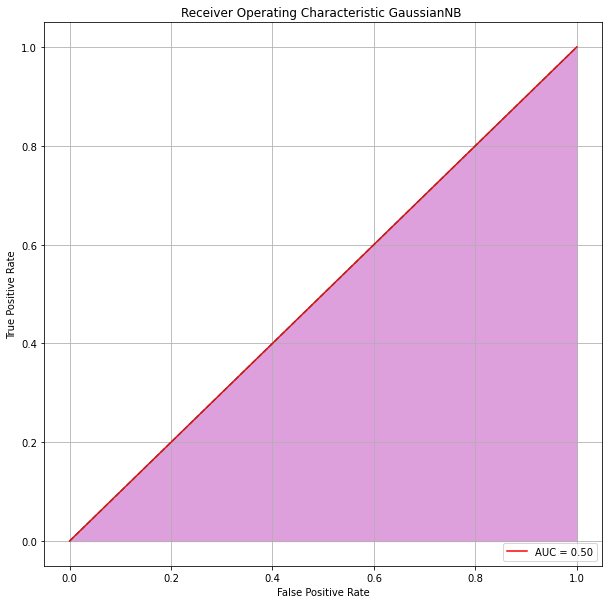

In [129]:
#Visualization receiver Operating Characteristic GaussianNB
y_prob = gnb.predict_proba(X_test)[:,1] 
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(false_positive_rate, true_positive_rate)
print('AUROC:' ,roc_auc)
plt.figure(figsize=(10,10))
plt.title('Receiver Operating Characteristic GaussianNB ')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--', color='brown')
plt.fill_between(false_positive_rate, true_positive_rate, color='plum')
plt.grid()
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()    

GaussianNB affiche une AUROC de 0.5 (comme classifier aléatoire).Cette valeur sera notre valeur de référence.

### 2.3. Reduction des variables avec LassoCV

Après la transformation, nous avons 247 variables. Nous souhaitons de réduire leur nombre.

Nous avons sélectionné la méthode LassoCV. Si plusieurs variables corrélées contribuent à la prédiction de l'étiquette, le lasso va avoir tendance à choisir une seule d'entre elles (affectant un poids de 0 aux autres).  Cependant, laquelle de ces variables est choisie est aléatoire, et peut changer si l'on répète la procédure d'optimisation. Le lasso a donc tendance à être instable.

In [130]:
#nous utilison dataset complet pour selectionner les variables
X_feature = transformer(X)
feature_names = X_feature.columns


In [131]:
#identification 50 variables les plus importantes
clf_lasso = LassoCV().fit(X_feature, y)
importance = np.abs(clf_lasso.coef_)
idx_third = importance.argsort()[-3]
threshold = importance[idx_third] + 0.01

idx_features = (-importance).argsort()[:80]
name_features = np.array(feature_names)[idx_features]
print('Selected features: {}'.format(name_features))

Selected features: ['EXT_SOURCE_2' 'EXT_SOURCE_3' 'CREDIT_EN_COURS_APP' 'EXT_SOURCE_1'
 'CODE_GENDER_F' 'CREDIT_REFUSED_APP' 'AMT_ANNUITY' 'FLAG_OWN_CAR_N'
 'DAYS_EMPLOYED' 'AMT_GOODS_PRICE' 'CREDIT_ACTIVE_BUREAU'
 'NAME_EDUCATION_TYPE_Secondary / secondary special' 'DAYS_ENDDATE_FACT'
 'FLAG_DOCUMENT_3' 'NAME_INCOME_TYPE_Working'
 'NAME_CONTRACT_TYPE_Cash loans' 'DEF_30_CNT_SOCIAL_CIRCLE'
 'REGION_RATING_CLIENT_W_CITY' 'CREDIT_TERM' 'DAYS_ID_PUBLISH'
 'REG_CITY_NOT_LIVE_CITY' 'NAME_FAMILY_STATUS_Married'
 'DIFF_AMOUNT_PAYMENT' 'ORGANIZATION_TYPE_Self-employed'
 'OCCUPATION_TYPE_Low-skill Laborers'
 'NAME_EDUCATION_TYPE_Higher education'
 'ORGANIZATION_TYPE_Transport: type 3' 'FLAG_DOCUMENT_18'
 'FLAG_DOCUMENT_16' 'NAME_INCOME_TYPE_Pensioner' 'FLAG_WORK_PHONE'
 'ORGANIZATION_TYPE_Construction' 'OCCUPATION_TYPE_Core staff'
 'DIFF_DAY_PAYMENT' 'OCCUPATION_TYPE_Drivers'
 'NAME_EDUCATION_TYPE_Lower secondary' 'NB_CASH'
 'ORGANIZATION_TYPE_Trade: type 2' 'DEF_60_CNT_SOCIAL_CIRCLE'
 'DAYS_LA

In [132]:
#pour garder l'identifiant
X_train = X_train[np.append(name_features,['SK_ID_CURR'])]
X_test = X_test[np.append(name_features,['SK_ID_CURR'])]


### 2.4. Modeling

Selection des modèles à tester

In [133]:
models = []
models.append(('LogisticRegression', LogisticRegression(solver = 'liblinear')))
models.append(('DecisionTreeClassifier', DecisionTreeClassifier()))
models.append(('SGDClassifier',SGDClassifier(loss = 'log')))
models.append(('RandomForestClassifier', RandomForestClassifier()))


Nous utilisons la méthode model_selection.StratifiedKFold pour créer les folds d’une validation croisée stratifiée.

Si l’on ne répartit pas les points positifs de manière équilibrée entre les différents folds, les jeux d’entraînement et de test auront des proportions différentes de positifs et négatifs, ce qui peut biaiser les résultats.


In [134]:
folds = StratifiedKFold(n_splits=10, shuffle=True, random_state= 23)

In [135]:
# performance metrics
scoring = {'accuracy':make_scorer(accuracy_score), 
           'precision':make_scorer(precision_score),
           'recall':make_scorer(recall_score), 
           'f1_score':make_scorer(f1_score),
           'roc_auc':make_scorer(roc_auc_score, needs_proba =True)}
scoring_name =['Accuracy', 'Precision', 'Recall','F1 Score','ROC_AUC' ]

In [136]:
X_train.head()

,EXT_SOURCE_2,EXT_SOURCE_3,CREDIT_EN_COURS_APP,EXT_SOURCE_1,CODE_GENDER_F,CREDIT_REFUSED_APP,AMT_ANNUITY,FLAG_OWN_CAR_N,DAYS_EMPLOYED,AMT_GOODS_PRICE,CREDIT_ACTIVE_BUREAU,NAME_EDUCATION_TYPE_Secondary / secondary special,DAYS_ENDDATE_FACT,FLAG_DOCUMENT_3,NAME_INCOME_TYPE_Working,NAME_CONTRACT_TYPE_Cash loans,DEF_30_CNT_SOCIAL_CIRCLE,REGION_RATING_CLIENT_W_CITY,CREDIT_TERM,DAYS_ID_PUBLISH,REG_CITY_NOT_LIVE_CITY,NAME_FAMILY_STATUS_Married,DIFF_AMOUNT_PAYMENT,ORGANIZATION_TYPE_Self-employed,OCCUPATION_TYPE_Low-skill Laborers,NAME_EDUCATION_TYPE_Higher education,ORGANIZATION_TYPE_Transport: type 3,FLAG_DOCUMENT_18,FLAG_DOCUMENT_16,NAME_INCOME_TYPE_Pensioner,FLAG_WORK_PHONE,ORGANIZATION_TYPE_Construction,OCCUPATION_TYPE_Core staff,DIFF_DAY_PAYMENT,OCCUPATION_TYPE_Drivers,NAME_EDUCATION_TYPE_Lower secondary,NB_CASH,ORGANIZATION_TYPE_Trade: type 2,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,ORGANIZATION_TYPE_Military,DAYS_REGISTRATION,NAME_INCOME_TYPE_Unemployed,SK_DPD_DEF_CASH,AMT_CREDIT_SUM_OVERDUE,ORGANIZATION_TYPE_Industry: type 9,FLOORSMAX_MODE,FLAG_PHONE,ORGANIZATION_TYPE_Bank,FLAG_DOCUMENT_13,NAME_FAMILY_STATUS_Civil marriage,OCCUPATION_TYPE_High skill tech staff,NAME_FAMILY_STATUS_Widow,ENTRANCES_MODE,NAME_HOUSING_TYPE_House / apartment,FLAG_DOCUMENT_11,DAYS_CREDIT_ENDDATE,ORGANIZATION_TYPE_Security Ministries,AMT_REQ_CREDIT_BUREAU_QRT,FLAG_DOCUMENT_14,NAME_HOUSING_TYPE_Office apartment,REG_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE_Police,AMT_CREDIT_SUM,FLAG_DOCUMENT_2,ORGANIZATION_TYPE_Realtor,CNT_CHILDREN,NAME_HOUSING_TYPE_Municipal apartment,OCCUPATION_TYPE_Accountants,NAME_INCOME_TYPE_Maternity leave,FLAG_OWN_REALTY_N,WEEKDAY_APPR_PROCESS_START_MONDAY,FLAG_OWN_CAR_Y,NAME_CONTRACT_TYPE_Revolving loans,FLAG_OWN_REALTY_Y,ORGANIZATION_TYPE_Agriculture,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Advertising,SK_ID_CURR
146107,0.903948,1.508550,0.098573,0.000148,-1.389366,0.378835,-1.085313,0.716903,0.000795,-0.857909,-0.637891,0.636833,0.256192,-1.569752,-1.032263,0.324497,-0.319849,-0.062491,-0.694355,-1.097999,-0.29105,-1.328691,-0.029599,-0.378819,-0.083866,-0.566297,-0.061487,-0.090042,-0.100471,2.133630,-0.49933,-0.149378,-0.31232,0.060985,-0.254738,-0.110357,0.012831,-0.078661,-0.275540,-1.461763,-0.092875,0.485429,-0.007944,-0.041412,-0.011739,-0.105054,1.093024,-0.624909,-0.089603,-0.059671,3.055863,-0.195624,-0.235303,-0.588522,0.356358,-0.061883,-0.219080,-0.080147,-0.464319,-0.054984,-0.092689,-0.547761,-0.087036,-0.362625,-0.006231,-0.036758,-0.576322,-0.194014,-0.181946,-0.003816,1.50333,-0.445684,-0.716903,-0.324497,-1.50333,-0.089603,-0.460128,-0.235004,-0.450603,-0.037414,-0.086497
205716,0.599465,-2.143357,-0.602968,0.155826,0.719753,-0.893460,0.752982,0.716903,0.307870,1.690136,1.170243,0.636833,0.542774,0.637043,-1.032263,0.324497,1.907241,-2.050022,-0.953963,-0.707391,-0.29105,0.752621,-0.029599,-0.378819,-0.083866,-0.566297,-0.061487,-0.090042,-0.100471,-0.468685,-0.49933,-0.149378,-0.31232,0.649696,-0.254738,-0.110357,-0.571634,-0.078661,2.471816,0.668220,-0.092875,1.360715,-0.007944,-0.041412,-0.011739,-0.105054,-0.545286,-0.624909,-0.089603,-0.059671,-0.327240,-0.195624,-0.235303,-0.102158,0.356358,-0.061883,1.694749,-0.080147,-0.464319,-0.054984,-0.092689,-0.547761,-0.087036,0.701749,-0.006231,-0.036758,0.810821,-0.194014,-0.181946,-0.003816,1.50333,-0.445684,-0.716903,-0.324497,-1.50333,-0.089603,-0.460128,-0.235004,-0.450603,-0.037414,0.585632
97310,-0.235584,0.243293,-0.602968,0.660053,0.719753,0.060761,1.711308,-1.394888,0.779224,0.729818,-0.001012,-1.570271,0.769882,0.637043,-1.032263,0.324497,-0.319849,-0.062491,-0.011504,0.825910,-0.29105,0.752621,-0.842872,-0.378819,-0.083866,1.765857,-0.061487,-0.090042,-0.100471,-0.468685,-0.49933,-0.149378,-0.31232,0.389746,-0.254738,-0.110357,1.991022,-0.078661,-0.275540,1.164127,-0.092875,-1.340119,-0.007944,-0.041412,-0.011739,-0.105054,-1.774509,-0.624909,-0.089603,-0.059671,-0

 Nous allons d'abord tester les scores sans les nouvelles variables :'CREDIT_EN_COURS_APP','CREDIT_TERM','CREDIT_REFUSED_APP'

In [137]:
variables_a_exclure = ['CREDIT_REFUSED_APP','CREDIT_TERM','CREDIT_EN_COURS_APP']
X_sans_variables = X_train.drop(variables_a_exclure,axis = 1)

In [138]:
table_compare_models(models,X_sans_variables,y_train,folds,scoring,scoring_name)

,LogisticRegression,DecisionTreeClassifier,SGDClassifier,RandomForestClassifier,Best Score
Accuracy,0.918857,0.852222,0.918357,0.918935,RandomForestClassifier
Precision,0.509925,0.144367,0.444998,0.638961,RandomForestClassifier
Recall,0.012796,0.166658,0.022424,0.003229,DecisionTreeClassifier
F1 Score,0.024954,0.154683,0.042482,0.006422,DecisionTreeClassifier
ROC_AUC,0.747884,0.539720,0.736566,0.725644,LogisticRegression


 Avec les nouvelles variables 

In [139]:
X_train.head()

,EXT_SOURCE_2,EXT_SOURCE_3,CREDIT_EN_COURS_APP,EXT_SOURCE_1,CODE_GENDER_F,CREDIT_REFUSED_APP,AMT_ANNUITY,FLAG_OWN_CAR_N,DAYS_EMPLOYED,AMT_GOODS_PRICE,CREDIT_ACTIVE_BUREAU,NAME_EDUCATION_TYPE_Secondary / secondary special,DAYS_ENDDATE_FACT,FLAG_DOCUMENT_3,NAME_INCOME_TYPE_Working,NAME_CONTRACT_TYPE_Cash loans,DEF_30_CNT_SOCIAL_CIRCLE,REGION_RATING_CLIENT_W_CITY,CREDIT_TERM,DAYS_ID_PUBLISH,REG_CITY_NOT_LIVE_CITY,NAME_FAMILY_STATUS_Married,DIFF_AMOUNT_PAYMENT,ORGANIZATION_TYPE_Self-employed,OCCUPATION_TYPE_Low-skill Laborers,NAME_EDUCATION_TYPE_Higher education,ORGANIZATION_TYPE_Transport: type 3,FLAG_DOCUMENT_18,FLAG_DOCUMENT_16,NAME_INCOME_TYPE_Pensioner,FLAG_WORK_PHONE,ORGANIZATION_TYPE_Construction,OCCUPATION_TYPE_Core staff,DIFF_DAY_PAYMENT,OCCUPATION_TYPE_Drivers,NAME_EDUCATION_TYPE_Lower secondary,NB_CASH,ORGANIZATION_TYPE_Trade: type 2,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,ORGANIZATION_TYPE_Military,DAYS_REGISTRATION,NAME_INCOME_TYPE_Unemployed,SK_DPD_DEF_CASH,AMT_CREDIT_SUM_OVERDUE,ORGANIZATION_TYPE_Industry: type 9,FLOORSMAX_MODE,FLAG_PHONE,ORGANIZATION_TYPE_Bank,FLAG_DOCUMENT_13,NAME_FAMILY_STATUS_Civil marriage,OCCUPATION_TYPE_High skill tech staff,NAME_FAMILY_STATUS_Widow,ENTRANCES_MODE,NAME_HOUSING_TYPE_House / apartment,FLAG_DOCUMENT_11,DAYS_CREDIT_ENDDATE,ORGANIZATION_TYPE_Security Ministries,AMT_REQ_CREDIT_BUREAU_QRT,FLAG_DOCUMENT_14,NAME_HOUSING_TYPE_Office apartment,REG_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE_Police,AMT_CREDIT_SUM,FLAG_DOCUMENT_2,ORGANIZATION_TYPE_Realtor,CNT_CHILDREN,NAME_HOUSING_TYPE_Municipal apartment,OCCUPATION_TYPE_Accountants,NAME_INCOME_TYPE_Maternity leave,FLAG_OWN_REALTY_N,WEEKDAY_APPR_PROCESS_START_MONDAY,FLAG_OWN_CAR_Y,NAME_CONTRACT_TYPE_Revolving loans,FLAG_OWN_REALTY_Y,ORGANIZATION_TYPE_Agriculture,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Advertising,SK_ID_CURR
146107,0.903948,1.508550,0.098573,0.000148,-1.389366,0.378835,-1.085313,0.716903,0.000795,-0.857909,-0.637891,0.636833,0.256192,-1.569752,-1.032263,0.324497,-0.319849,-0.062491,-0.694355,-1.097999,-0.29105,-1.328691,-0.029599,-0.378819,-0.083866,-0.566297,-0.061487,-0.090042,-0.100471,2.133630,-0.49933,-0.149378,-0.31232,0.060985,-0.254738,-0.110357,0.012831,-0.078661,-0.275540,-1.461763,-0.092875,0.485429,-0.007944,-0.041412,-0.011739,-0.105054,1.093024,-0.624909,-0.089603,-0.059671,3.055863,-0.195624,-0.235303,-0.588522,0.356358,-0.061883,-0.219080,-0.080147,-0.464319,-0.054984,-0.092689,-0.547761,-0.087036,-0.362625,-0.006231,-0.036758,-0.576322,-0.194014,-0.181946,-0.003816,1.50333,-0.445684,-0.716903,-0.324497,-1.50333,-0.089603,-0.460128,-0.235004,-0.450603,-0.037414,-0.086497
205716,0.599465,-2.143357,-0.602968,0.155826,0.719753,-0.893460,0.752982,0.716903,0.307870,1.690136,1.170243,0.636833,0.542774,0.637043,-1.032263,0.324497,1.907241,-2.050022,-0.953963,-0.707391,-0.29105,0.752621,-0.029599,-0.378819,-0.083866,-0.566297,-0.061487,-0.090042,-0.100471,-0.468685,-0.49933,-0.149378,-0.31232,0.649696,-0.254738,-0.110357,-0.571634,-0.078661,2.471816,0.668220,-0.092875,1.360715,-0.007944,-0.041412,-0.011739,-0.105054,-0.545286,-0.624909,-0.089603,-0.059671,-0.327240,-0.195624,-0.235303,-0.102158,0.356358,-0.061883,1.694749,-0.080147,-0.464319,-0.054984,-0.092689,-0.547761,-0.087036,0.701749,-0.006231,-0.036758,0.810821,-0.194014,-0.181946,-0.003816,1.50333,-0.445684,-0.716903,-0.324497,-1.50333,-0.089603,-0.460128,-0.235004,-0.450603,-0.037414,0.585632
97310,-0.235584,0.243293,-0.602968,0.660053,0.719753,0.060761,1.711308,-1.394888,0.779224,0.729818,-0.001012,-1.570271,0.769882,0.637043,-1.032263,0.324497,-0.319849,-0.062491,-0.011504,0.825910,-0.29105,0.752621,-0.842872,-0.378819,-0.083866,1.765857,-0.061487,-0.090042,-0.100471,-0.468685,-0.49933,-0.149378,-0.31232,0.389746,-0.254738,-0.110357,1.991022,-0.078661,-0.275540,1.164127,-0.092875,-1.340119,-0.007944,-0.041412,-0.011739,-0.105054,-1.774509,-0.624909,-0.089603,-0.059671,-0

In [140]:
table_compare_models(models,X_train,y_train,folds,scoring,scoring_name)

,LogisticRegression,DecisionTreeClassifier,SGDClassifier,RandomForestClassifier,Best Score
Accuracy,0.918935,0.852207,0.918576,0.918964,RandomForestClassifier
Precision,0.520242,0.146778,0.480416,0.723083,RandomForestClassifier
Recall,0.016564,0.170723,0.022543,0.003229,DecisionTreeClassifier
F1 Score,0.032091,0.157817,0.042916,0.006424,DecisionTreeClassifier
ROC_AUC,0.752266,0.541565,0.741725,0.728305,LogisticRegression


Nous constatons qu’après l’ajout des trois nouvelles variables la valeur de ROC AUC est augmentée.

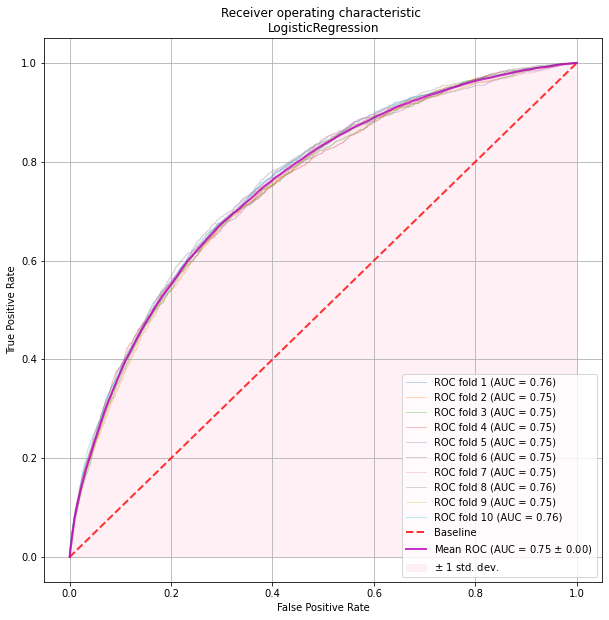

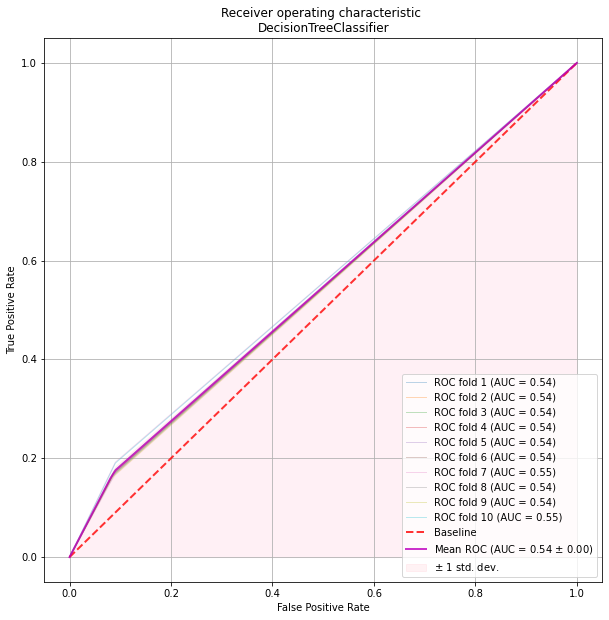

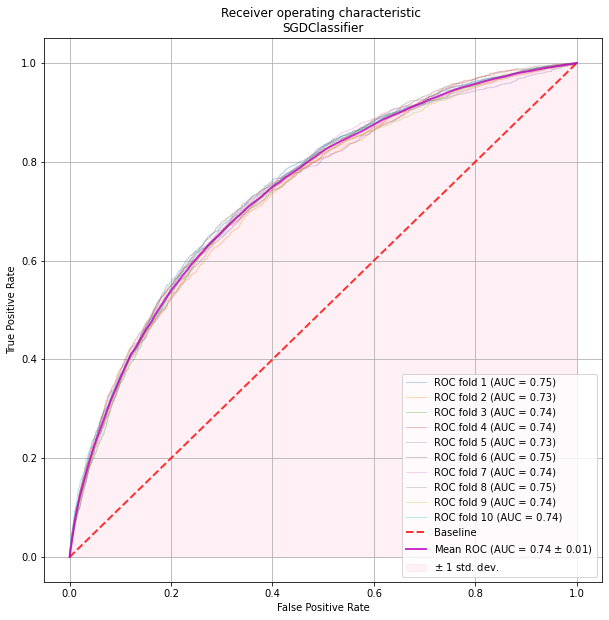

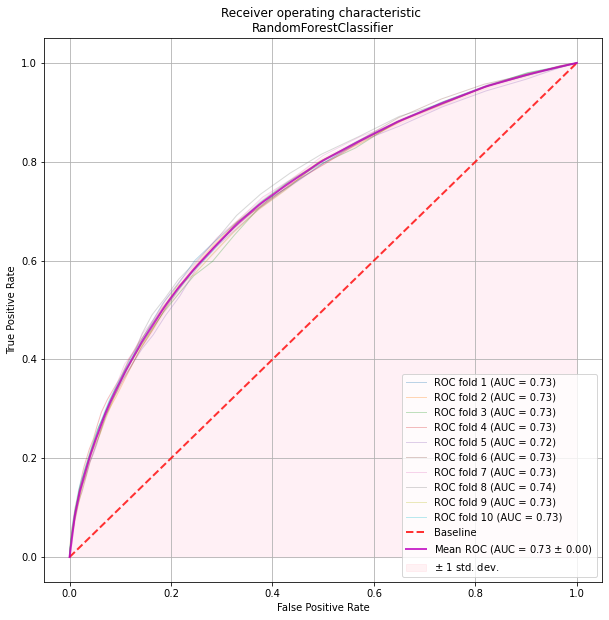

In [141]:
cross_validation_ROC(models,X_train,y_train,folds)

1.8236875438690185 0.011102566719055176


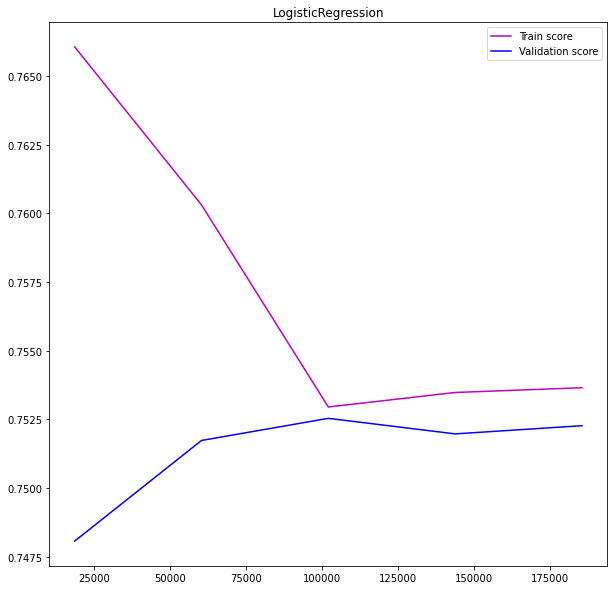

4.759446334838867 0.017204747200012208


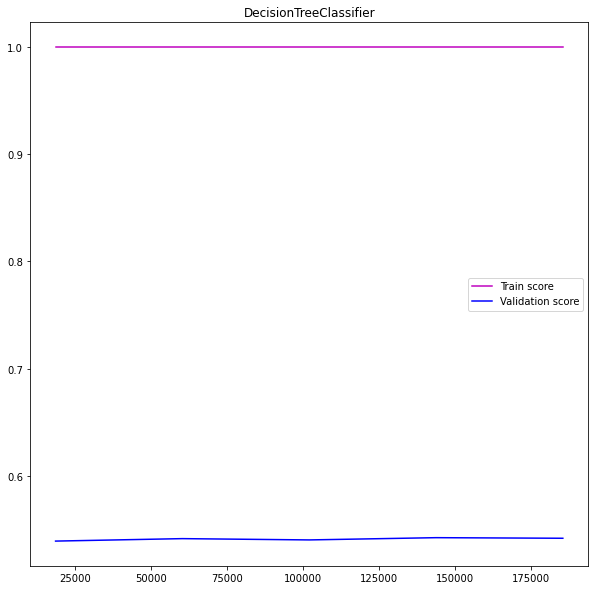

1.0955916881561278 0.012888069152832032


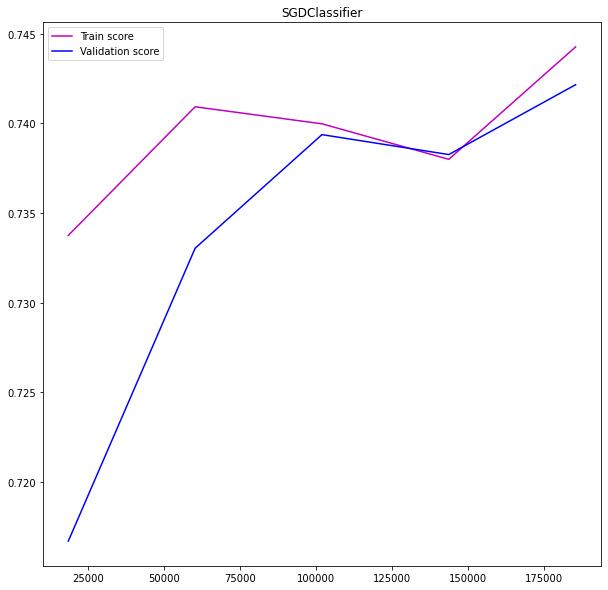

30.413675870895386 0.4450295114517212


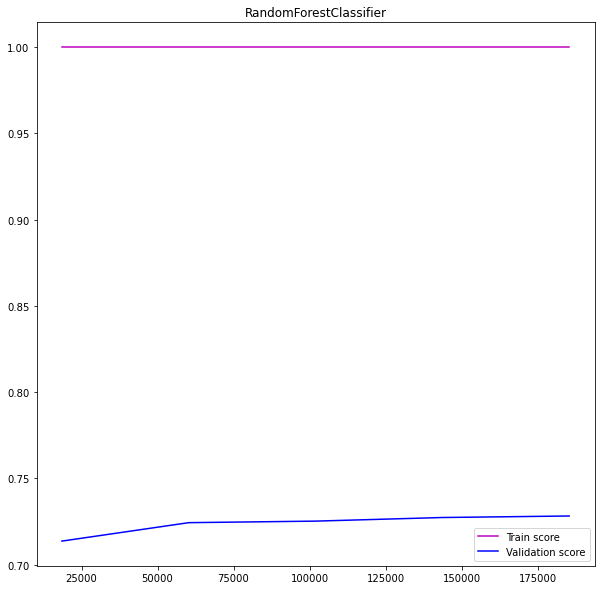

In [142]:
vizualization_learning_curve(models,X_train,y_train,folds)

 Nous constatons que LogisticRegression montre un meilleur résultat.

### 2.5. Optimisation de hyperparameters

In [143]:
#création notre modèle
lrg = LogisticRegression(solver = 'liblinear')

In [144]:
#Affichage de paramètres
lrg.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'liblinear',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

Nous avons sélectionné trois paramètres pour améliorer notre modèle:
 - 'penalty' : type de regularisation
 - 'C': des valeurs plus petites indiquent une régularisation plus forte
 - 'max_iter': nombre maximal des itérations

In [145]:
params ={'penalty':['l2','l1'],'C':[0.001,0.01,0.1],'max_iter':[100,200,300]}

In [146]:
#Retrouvons les meilleurs paramètres avec GridSearchCV et cross-validation
clf = GridSearchCV(lrg,params,scoring='roc_auc',cv=folds)
clf.fit(X_train,y_train)
print('Best roc_auc: {:.4}, with best params: {}'.format(clf.best_score_, clf.best_params_))

Best roc_auc: 0.7523, with best params: {'C': 0.1, 'max_iter': 300, 'penalty': 'l1'}


### 2.6. Feature Importances

Pour identifier les variables les plus importantes pour notre modèle, nous avons utilisé l'algorithme RFE (Recursive Feature Elimination)
 
Le principe de cet algorithme est d’éliminer récursivement les variables les moins importantes pour le modèle jusqu’à ce que le nombre de variables défini dans les paramètres soit atteinte.
 
D’abord, un modèle pour l'ensemble des variables est créé et le score d'importance de chaque variable est calculé. Ensuite, les variables les moins importantes sont supprimées, le modèle est reconstruit et les scores d'importance sont calculés à nouveau. 

In [147]:
#selection dix variables plus importantes
rfe = RFE(estimator=clf.best_estimator_,n_features_to_select=10)
rfe.fit(X_train,y_train)

RFE(estimator=LogisticRegression(C=0.1, max_iter=300, penalty='l1',
                                 solver='liblinear'),
    n_features_to_select=10)

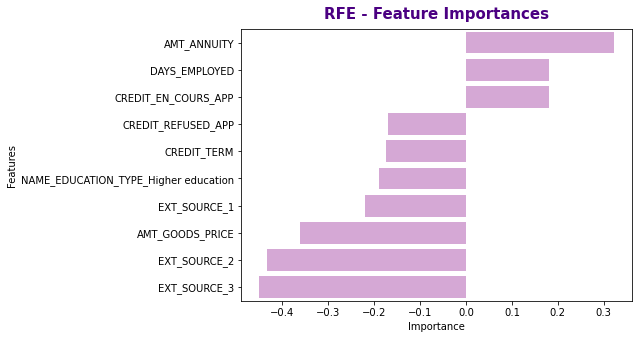

In [148]:
#Visualisation 10 variables plus importantes
dset = pd.DataFrame()
dset['Features'] = X_train.columns[rfe.get_support()]
dset['Importance'] = rfe.estimator_.coef_[0]
dset = dset.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(7, 5))
sns.barplot(x = 'Importance',y = 'Features',data =dset,color='plum' )
plt.title('RFE - Feature Importances', fontsize=15, color='indigo',fontweight='bold', pad=10)
plt.show()


Text(0.5, 1.05, 'Feature Importances')

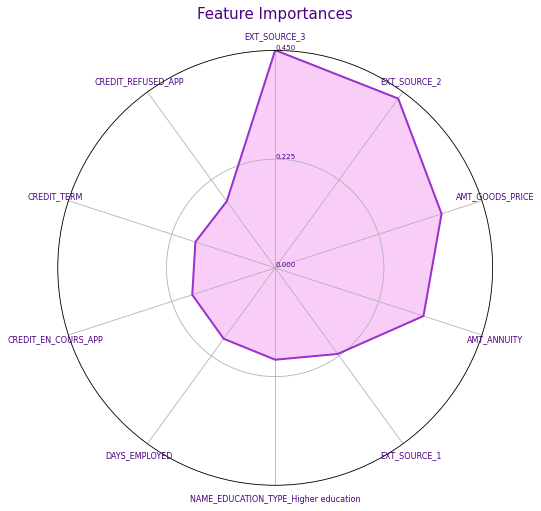

In [149]:
#Visualisation avec radar
dset['Importance_ABS'] = abs(dset['Importance'])
features_importance = dset.sort_values(by='Importance_ABS', ascending=False).head(10)
labels= features_importance['Features'].values
stats= features_importance['Importance_ABS'].values
N = len(labels)
fig = plt.figure(figsize=(10,8), facecolor='white') 
# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
 # Use a polar axes
ax = plt.subplot(111, polar=True)

# If you want the first axis to be on top:
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)
 
# Draw one axe per variable + add labels labels yet
plt.xticks(angles[:-1], labels, color='indigo', size=8)
 
# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks([0,0.225,0.45], color="indigo", size=7)
plt.ylim(0,0.45)
 
# Ind1
values=stats.flatten().tolist()
values += values[:1]
ax.plot(angles, values, color='darkorchid', linewidth=2, linestyle='solid')
ax.fill(angles, values, color='violet', alpha=0.4)
plt.title('Feature Importances', fontsize=15, color='indigo', pad=10);

Les variables les plus importantes pour notre modèle:

  - EXT_SOURCE_3
  - EXT_SOURCE_2 
  - AMT_GOODS_PRICE 


## Conclusion

Les quatre modèles de classifications supervisés qui retournent des scores de probabilité ont été testés: 
 - LogisticRegression
 - DecisionTreeClassifier
 - SGDClassifier
 - RandomForestClassifier
 
 
Leurs performances ont étés évaluées en fonction de la valeur AUROC.


LogisticRegression a montré le meilleur résultat parmi ces quatre modèles.


La performance du modèle a été améliorée par la création de nouvelles variables et l’adaptation d’hyperparamètres.


Les variables les plus importantes pour le modèle sélectionné ont étés identifiées à l’aide de la méthode REE. 


La capacité d’apprentissage du modèle peut être améliorée avec l’augmentation du nombre de variables sélectionnées et l’augmentation de la taille de l’échantillon.

Veuillez noter que les modèles très gourmands en ressources n’ont pas pu être testés suite une basse performance de l’équipement.
